In [ ]:
import random

# Probability of generating a '0' (adjust for desired bias)
bias = 0.6

binary_string = ''.join(random.choices(['0', '1'], weights=[bias, 1 - bias], k=10000))

print(binary_string[:50])  # Print first 50 digits for verification

10000100111100101011010000010011100000001110001000


In [ ]:
!pip install arc4 cryptography pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab import files

# Binary generator
def generate_binary_string(method, length=100000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

# Statistical tests
def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

# Generate primes up to 2^16
def generate_prime_set(limit=2**16):
    sieve = [True] * limit
    sieve[0:2] = [False, False]
    for i in range(2, int(limit**0.5) + 1):
        if sieve[i]:
            for j in range(i * i, limit, i):
                sieve[j] = False
    return {i for i, is_prime in enumerate(sieve) if is_prime}

# Density test with 32-bit chunks
def compute_density(binary_string, prime_set):
    match = other = 0
    for i in range(0, len(binary_string) - 31, 32):
        val = int(binary_string[i:i + 32], 2)
        if val in prime_set:
            match += 1
        else:
            other += 1
    total = match + other
    return match / total if total else 0, other / total if total else 0

# Main experiment
prime_set = generate_prime_set()
methods = ['aes128', 'rc4', 'zuc32']
num_observations = 100
results = []

for method in methods:
    for _ in range(num_observations):
        bin_str = generate_binary_string(method, length=100000)

        # Prime density and statistical tests
        prime_density, prime_other = compute_density(bin_str, prime_set)
        kl = kl_divergence(bin_str)
        chi = chi_squared_test(bin_str)
        runs = runs_test(bin_str)

        results.append({
            "Method": method,
            "Prime Density": prime_density,
            "Prime Other": prime_other,
            "KL Divergence": kl,
            "Chi-squared p-value": chi,
            "Runs Test p-value": runs
        })

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("prime_randomness_analysis.csv", index=False)
files.download("prime_randomness_analysis.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import os
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from scipy.stats import norm, entropy

# Binary generator
def generate_binary_string(method, length=1000000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

# Monobit (Frequency) Test — NIST SP 800-22
def monobit_frequency_test(bits):
    n = len(bits)
    s_obs = sum([1 if b == '1' else -1 for b in bits])
    s = abs(s_obs) / np.sqrt(n)
    p_value = 2 * (1 - norm.cdf(s))
    return p_value

# Entropy Test (Shannon entropy)
def entropy_test(bits):
    count0 = bits.count('0')
    count1 = bits.count('1')
    p0 = count0 / len(bits)
    p1 = count1 / len(bits)
    return -sum(p * np.log2(p) for p in [p0, p1] if p > 0)

# Autocorrelation Test
def autocorrelation_test(bits, lag=1):
    n = len(bits)
    matches = sum(bits[i] == bits[i + lag] for i in range(n - lag))
    score = (matches - (n - lag) / 2) / np.sqrt((n - lag) / 4)
    p_value = 2 * (1 - norm.cdf(abs(score)))
    return p_value

# Main experiment
methods = ['aes128', 'rc4', 'zuc32']
results = {}

for method in methods:
    print(f"Running tests for {method.upper()}...")
    binary_string = generate_binary_string(method)

    freq_p = monobit_frequency_test(binary_string)
    ent = entropy_test(binary_string)
    auto_p = autocorrelation_test(binary_string, lag=1)

    results[method] = {
        'Monobit Test p-value': freq_p,
        'Entropy': ent,
        'Autocorrelation p-value (lag=1)': auto_p
    }

# Final results
for method, metrics in results.items():
    print(f"\n{method.upper()} RESULTS:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.5f}")


Running tests for AES128...
Running tests for RC4...
Running tests for ZUC32...

AES128 RESULTS:
  Monobit Test p-value: 0.13413
  Entropy: 1.00000
  Autocorrelation p-value (lag=1): 0.86580

RC4 RESULTS:
  Monobit Test p-value: 0.71885
  Entropy: 1.00000
  Autocorrelation p-value (lag=1): 0.21832

ZUC32 RESULTS:
  Monobit Test p-value: 0.55922
  Entropy: 1.00000
  Autocorrelation p-value (lag=1): 0.32857


In [ ]:
binary_chunks = [binary_string[i:i + 5] for i in range(0, len(binary_string), 5)]
decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
frequency_dict = {i: 0 for i in range(32)}

for number in decimal_numbers:
    frequency_dict[number] += 1

for number, frequency in frequency_dict.items():
    print(f"{number}: {frequency}")

0: 326
1: 223
2: 197
3: 155
4: 215
5: 163
6: 130
7: 115
8: 184
9: 141
10: 150
11: 85
12: 142
13: 97
14: 110
15: 67


In [ ]:
import random
import pandas as pd

# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(50, 105, 5)]  # Bias from 0.5 to 1.0
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate biased binary string
    binary_string = ''.join(random.choices(['0', '1'], weights=[bias, 1 - bias], k=10000))

    # Apply the algorithm to get frequencies
    binary_chunks = [binary_string[i:i + 6] for i in range(0, len(binary_string), 6)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(64)}

    for number in decimal_numbers:
        frequency_dict[number] += 1

    all_frequencies.append(frequency_dict)

# Create DataFrame
df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Display DataFrame
display(df)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Bias,,,,,,,,,,,,,,,,,,,,,
0.50,21,35,32,30,22,22,33,21,20,22,...,26,25,25,24,24,32,24,19,28,29
0.55,55,38,35,27,34,42,31,31,38,32,...,26,13,21,25,21,16,23,12,15,11
0.60,83,47,52,42,56,33,23,21,54,39,...,17,14,21,10,18,13,20,8,11,6
0.65,127,67,53,35,47,50,31,19,66,51,...,13,4,7,10,14,3,5,6,8,2
0.70,195,88,86,34,98,39,30,19,73,30,...,5,8,22,8,4,3,2,5,8,2
0.75,302,107,101,24,101,26,28,13,76,36,...,4,2,4,6,4,1,4,2,2,0
0.80,392,107,98,29,126,19,31,8,111,17,...,2,1,8,3,2,0,1,0,0,0
0.85,635,115,113,20,95,22,15,4,104,21,...,3,0,5,1,0,0,1,1,0,0
0.90,895,98,94,8,90,12,11,2,104,10,...,0,0,2,0,0,0,0,0,0,0


In [ ]:
import random
import pandas as pd

def is_prime(n):
  """Checks if a number is prime."""
  if n <= 1:
    return False
  if n <= 3:
    return True
  if n % 2 == 0 or n % 3 == 0:
    return False
  i = 5
  while i * i <= n:
    if n % i == 0 or n % (i + 2) == 0:
      return False
    i += 6
  return True

# Probability of generating a '0' (adjust for desired bias)
bias = 0.5

binary_string = ''.join(random.choices(['0', '1'], weights=[bias, 1 - bias], k=10000))

binary_chunks = [binary_string[i:i + 8] for i in range(0, len(binary_string), 8)]
decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
frequency_dict = {i: 0 for i in range(256)}

for number in decimal_numbers:
    frequency_dict[number] += 1

# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(50, 105, 5)]  # Bias from 0.5 to 1.0
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate biased binary string
    binary_string = ''.join(random.choices(['0', '1'], weights=[bias, 1 - bias], k=10000))

    # Apply the algorithm to get frequencies
    binary_chunks = [binary_string[i:i + 8] for i in range(0, len(binary_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(256)}

    for number in decimal_numbers:
        frequency_dict[number] += 1

    all_frequencies.append(frequency_dict)

# Create DataFrame
df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Add prime and composite density columns
prime_counts = []
composite_counts = []

for index in df.index:
  primes = 0
  composites = 0
  for col in df.columns:
    if is_prime(col):
      primes += df.loc[index, col]
    elif col not in (0,1):
      composites += df.loc[index, col]

  prime_counts.append(primes / sum(df.loc[index]))
  composite_counts.append(composites / sum(df.loc[index]))

df['Prime Density'] = prime_counts
df['Composite Density'] = composite_counts

# Display DataFrame
display(df)


,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Prime Density,Composite Density
Bias,,,,,,,,,,,,,,,,,,,,,
0.50,4,6,5,5,9,7,8,6,5,5,...,4,3,3,7,5,7,7,5,0.2176,0.7744
0.55,7,11,9,8,11,11,6,4,8,8,...,5,3,2,3,1,3,2,0,0.1960,0.7896
0.60,19,13,12,16,13,7,13,2,7,12,...,2,1,3,3,3,0,3,0,0.1864,0.7880
0.65,32,28,24,9,22,15,4,6,23,10,...,1,1,1,1,0,0,1,0,0.1576,0.7944
0.70,60,31,27,13,38,13,11,5,54,10,...,0,1,0,0,0,1,0,0,0.1512,0.7760
0.75,117,45,38,16,51,18,14,3,38,8,...,2,0,1,0,0,0,0,0,0.1448,0.7256
0.80,198,52,45,14,53,11,15,3,60,12,...,0,0,0,0,0,0,0,0,0.1040,0.6960
0.85,346,50,65,8,54,7,9,2,66,6,...,0,0,0,0,0,0,0,0,0.0976,0.5856
0.90,555,72,59,9,50,6,4,1,54,3,...,0,0,0,0,0,0,0,0,0.0728,0.4256


In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Display DataFrame
display(df)

<ipython-input-16-5d1cf6e59269>:9: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-16-5d1cf6e59269>:9: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,Prime Density,Composite Density,KL Divergence
Bias,,,,,,,,,,,,,,,,,,,,,
0.50,4,6,5,5,9,7,8,6,5,5,...,3,3,7,5,7,7,5,0.2176,0.7744,0.106622
0.55,7,11,9,8,11,11,6,4,8,8,...,3,2,3,1,3,2,0,0.1960,0.7896,0.146487
0.60,19,13,12,16,13,7,13,2,7,12,...,1,3,3,3,0,3,0,0.1864,0.7880,0.294136
0.65,32,28,24,9,22,15,4,6,23,10,...,1,1,1,0,0,1,0,0.1576,0.7944,0.465003
0.70,60,31,27,13,38,13,11,5,54,10,...,1,0,0,0,1,0,0,0.1512,0.7760,0.731349
0.75,117,45,38,16,51,18,14,3,38,8,...,0,1,0,0,0,0,0,0.1448,0.7256,1.112705
0.80,198,52,45,14,53,11,15,3,60,12,...,0,0,0,0,0,0,0,0.1040,0.6960,1.588673
0.85,346,50,65,8,54,7,9,2,66,6,...,0,0,0,0,0,0,0,0.0976,0.5856,2.268620
0.90,555,72,59,9,50,6,4,1,54,3,...,0,0,0,0,0,0,0,0.0728,0.4256,3.012096


In [ ]:
import scipy.stats as stats
import numpy as np
from google.colab import files


def check_randomness(binary_string):
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p  # Return the p-value

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate and store p-values and KL Divergences
p_values = []
kl_divergences = []
for bias in df.index:
    binary_string = ''.join(random.choices(['0', '1'], weights=[bias, 1 - bias], k=10000))
    p_values.append(check_randomness(binary_string))

    observed_probs = [binary_string.count('0') / len(binary_string), binary_string.count('1') / len(binary_string)]
    expected_probs = [0.5, 0.5]
    kl_divergences.append(kl_divergence(observed_probs, expected_probs))

# Add p-value and KL Divergence columns to DataFrame
df['p-value'] = p_values
df['KL Divergence'] = kl_divergences

# Download the updated DataFrame as a CSV file
df.to_csv('bias_frequencies.csv', index=True)
files.download('bias_frequencies.csv')

<ipython-input-17-150367a2de3e>:17: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-17-150367a2de3e>:17: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Robbin miller

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from google.colab import files

# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(50, 105, 5)]  # Bias from 0.5 to 1.0
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate biased binary string using uniform distribution
    binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])

    # Apply the algorithm to get frequencies
    binary_chunks = [binary_string[i:i + 4] for i in range(0, len(binary_string), 4)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(16)}

    for number in decimal_numbers:
        frequency_dict[number] += 1

    all_frequencies.append(frequency_dict)

# Create DataFrame
df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Display DataFrame
display(df)

import scipy.stats as stats
import numpy as np
from google.colab import files


def check_randomness(binary_string):
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p  # Return the p-value

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate and store p-values and KL Divergences
p_values = []
kl_divergences = []
for bias in df.index:
    binary_string = ''.join(random.choices(['0', '1'], weights=[bias, 1 - bias], k=10000))
    p_values.append(check_randomness(binary_string))

    observed_probs = [binary_string.count('0') / len(binary_string), binary_string.count('1') / len(binary_string)]
    expected_probs = [0.5, 0.5]
    kl_divergences.append(kl_divergence(observed_probs, expected_probs))

# Add p-value and KL Divergence columns to DataFrame
df['p-value'] = p_values
df['KL Divergence'] = kl_divergences

# Download the updated DataFrame as a CSV file
df.to_csv('bias_frequencies.csv', index=True)
files.download('bias_frequencies.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Bias,,,,,,,,,,,,,,,,
0.50,151,153,161,144,162,145,162,173,159,166,152,133,142,149,174,174
0.55,238,181,198,156,180,160,152,103,196,164,146,127,160,114,122,103
0.60,315,217,200,138,198,155,158,101,224,142,144,97,150,111,88,62
0.65,452,237,254,129,249,111,125,71,244,130,129,72,130,62,69,36
0.70,573,275,241,92,266,102,108,56,292,114,95,55,118,47,50,16
0.75,775,285,285,80,253,99,96,36,248,69,99,28,83,29,28,7
0.80,1057,239,241,54,237,72,67,15,256,78,62,18,62,14,22,6
0.85,1308,233,249,44,219,29,37,9,222,37,46,10,41,8,7,1
0.90,1648,192,171,21,207,22,14,2,161,15,16,4,26,1,0,0


<ipython-input-22-9c37246f5a55>:50: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-22-9c37246f5a55>:50: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import base64
from google.colab import files  # Import files for download

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def generate_binary_string(method):
    """Generates a binary string using the specified method."""
    if method == 'uniform':
        return ''.join(['0' if i % 2 == 0 else '1' for i in range(10000)])
    elif method == 'random':
        return ''.join(np.random.choice(['0', '1'], size=10000))
    elif method == 'aes128':
        password = b"password"  # Replace with a strong password
        salt = os.urandom(16)
        # Generate a 32-byte key instead of 16
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=32,  # Changed to 32 for a 256-bit key
            salt=salt,
            iterations=1,  # Single iteration
        )
        key = base64.urlsafe_b64encode(kdf.derive(password))
        f = Fernet(key)
        aes_string = ""
        # Encrypt data to obtain 10000 bits
        token = f.encrypt(os.urandom(1250))  # Encrypt to get 10000 bits
        aes_string = ''.join(format(byte, '08b') for byte in token)[:10000]
        return aes_string
    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        # Generate 10000 bits directly
        rc4_string = ''.join(format(byte, '08b') for byte in cipher.encrypt(os.urandom(1250)))[:10000]
        return rc4_string
    else:
        raise ValueError(f"Invalid method: {method}")

def check_randomness(binary_string):
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p  # Return the p-value

# Create an empty list to store the results
results = []

# Loop through each method and generate 1 string
for method in ['uniform', 'random', 'aes128', 'rc4']:
    binary_string = generate_binary_string(method)
    observed_probs = [binary_string.count('0') / len(binary_string), binary_string.count('1') / len(binary_string)]
    kl_div = kl_divergence(observed_probs, [0.5, 0.5])
    p_value = check_randomness(binary_string)
    results.append({'Method': method, 'KL Divergence': kl_div, 'p-value': p_value, 'String': binary_string})  # Include the string

# Create a Pandas DataFrame from the results
df = pd.DataFrame(results)

# Download the DataFrame as a CSV file
df.to_csv('kl_divergence_results.csv', index=False)
files.download('kl_divergence_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Display DataFrame
display(df)

<ipython-input-29-5d1cf6e59269>:9: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-29-5d1cf6e59269>:9: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,Prime Density,Composite Density,KL Divergence
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1666,0.000000,1.000000,4.179560
0.05,0,0,0,0,0,0,0,0,0,1,...,5,2,62,5,66,67,1215,0.157169,0.842831,2.959775
0.10,0,0,0,0,0,0,0,2,0,0,...,9,9,102,9,101,93,879,0.281344,0.718656,2.246211
0.15,0,1,0,1,0,0,1,1,0,1,...,21,15,113,22,118,103,638,0.313737,0.685663,1.691726
0.20,0,0,1,2,0,1,1,5,0,0,...,28,29,100,18,117,113,462,0.350930,0.649070,1.252474
0.25,0,1,3,4,0,5,6,6,1,8,...,37,38,102,39,98,89,309,0.348530,0.650870,0.837000
0.30,0,4,6,13,0,7,10,16,0,6,...,23,31,83,35,91,79,190,0.374325,0.623275,0.525609
0.35,4,5,5,11,8,6,10,22,4,19,...,40,41,75,36,59,63,142,0.345531,0.649070,0.333775
0.40,10,4,12,14,10,14,8,23,9,6,...,25,37,47,42,45,40,79,0.332334,0.659268,0.169998


In [ ]:
import random
import pandas as pd
from google.colab import files
# Assuming 'df' from the previous code is still in memory.
# If not, reload it: df = pd.read_csv('your_file.csv', index_col='Bias')

def check_randomness(binary_string): # Define check_randomness in this scope
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p

#Recalculate p-values as the previous calculation was not correct for this dataframe
p_values = []
for bias in df.index:
  binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])
  p_values.append(check_randomness(binary_string))
df['p-value'] = p_values

# Download the updated DataFrame as a CSV file
df.to_csv('bias_frequencies.csv', index=True)
files.download('bias_frequencies.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

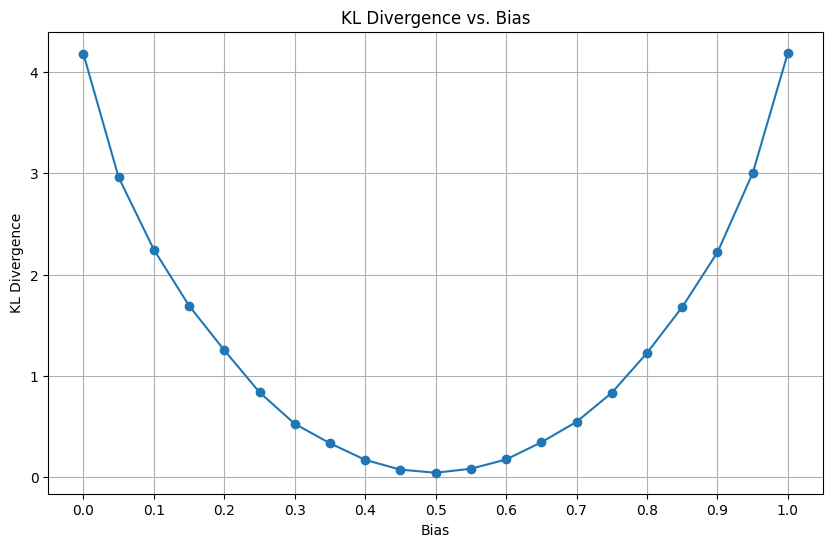

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'Bias' and 'KL Divergence' columns

plt.figure(figsize=(10, 6))
# Set x-axis ticks with 0.1 intervals
plt.xticks(np.arange(min(df.index), max(df.index) + 0.1, 0.1))
plt.plot(df.index, df['KL Divergence'], marker='o')
plt.xlabel('Bias')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs. Bias')
plt.grid(True)
plt.show()


Rabin Miller Primality Test

In [ ]:
import random

def rabin_miller_primality_test(n, k=5):
  """
  Checks if a number is prime using the Rabin-Miller primality test.

  Args:
      n: The number to test.
      k: The number of iterations to run. A higher value increases accuracy.

  Returns:
      True if the number is likely prime, False otherwise.
  """
  if n <= 1:
    return False
  if n <= 3:
    return True
  if n % 2 == 0:
    return False

  # Find (s, d) pair for n - 1 = 2**s * d such that d is odd
  s = 0
  d = n - 1
  while d % 2 == 0:
    s += 1
    d //= 2

  # Perform k iterations
  for _ in range(k):
    a = random.randrange(2, n - 1)
    x = pow(a, d, n)
    if x == 1 or x == n - 1:
      continue
    for _ in range(s - 1):
      x = pow(x, 2, n)
      if x == n - 1:
        break
    else:
      # Test failed, composite
      return False
  # All tests passed, likely prime
  return True

# Example usage:
number = 213
is_prime = rabin_miller_primality_test(number)
print(f"{number} is prime: {is_prime}")

213 is prime: False


In [ ]:
import numpy as np  # Import numpy for uniform distribution
import pandas as pd
import random

def rabin_miller_primality_test(n, k=5):
  if n <= 1:
    return False
  if n <= 3:
    return True
  if n % 2 == 0:
    return False

  # Find (s, d) pair for n - 1 = 2**s * d such that d is odd
  s = 0
  d = n - 1
  while d % 2 == 0:
    s += 1
    d //= 2

  # Perform k iterations
  for _ in range(k):
    a = random.randrange(2, n - 1)
    x = pow(a, d, n)
    if x == 1 or x == n - 1:
      continue
    for _ in range(s - 1):
      x = pow(x, 2, n)
      if x == n - 1:
        break
    else:
      # Test failed, composite
      return False
  # All tests passed, likely prime
  return True


# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(0, 105, 5)]  # Bias from 0.5 to 1.0
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate biased binary string using uniform distribution
    binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])

    # Apply the algorithm to get frequencies
    binary_chunks = [binary_string[i:i + 8] for i in range(0, len(binary_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(256)}
    for number in decimal_numbers:
        frequency_dict[number] += 1
    all_frequencies.append(frequency_dict)
df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Add prime and composite density columns
prime_counts = []
composite_counts = []
for index in df.index:
  primes = 0
  composites = 0
  for col in df.columns:
    if rabin_miller_primality_test(col):
      primes += df.loc[index, col]
    elif col not in (0,1):
      composites += df.loc[index, col]
  prime_counts.append(primes / sum(df.loc[index]))
  composite_counts.append(composites / sum(df.loc[index]))
df['Prime Density'] = prime_counts
df['Composite Density'] = composite_counts

# Display the DataFrame
display(df)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Prime Density,Composite Density
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1250,0.0000,1.0000
0.05,0,0,0,0,0,0,0,0,0,0,...,0,3,2,53,5,52,35,819,0.1864,0.8136
0.10,0,0,0,0,0,0,0,0,0,0,...,0,7,8,57,15,41,67,514,0.2640,0.7360
0.15,0,0,0,0,0,0,0,0,0,0,...,2,10,6,64,9,81,56,345,0.2672,0.7328
0.20,0,0,0,0,0,1,1,0,0,0,...,3,12,12,47,15,53,46,245,0.2656,0.7344
0.25,0,0,0,0,0,0,0,0,0,0,...,2,7,16,49,20,51,50,143,0.2472,0.7528
0.30,0,1,0,1,0,1,0,0,0,1,...,3,12,18,23,11,28,32,67,0.2304,0.7688
0.35,0,0,1,0,0,2,2,2,0,2,...,4,9,8,21,14,28,24,40,0.2400,0.7600
0.40,0,1,0,3,1,0,1,1,1,3,...,4,9,17,13,8,13,14,20,0.2392,0.7600


In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Display DataFrame
display(df)

/tmp/ipython-input-7-3210679936.py:9: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipython-input-7-3210679936.py:9: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,Prime Density,Composite Density,KL Divergence
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1250,0.0000,1.0000,5.546460
0.05,0,0,0,0,0,0,0,0,0,0,...,3,2,53,5,52,35,819,0.1864,0.8136,3.971158
0.10,0,0,0,0,0,0,0,0,0,0,...,7,8,57,15,41,67,514,0.2640,0.7360,2.889245
0.15,0,0,0,0,0,0,0,0,0,0,...,10,6,64,9,81,56,345,0.2672,0.7328,2.248758
0.20,0,0,0,0,0,1,1,0,0,0,...,12,12,47,15,53,46,245,0.2656,0.7344,1.743613
0.25,0,0,0,0,0,0,0,0,0,0,...,7,16,49,20,51,50,143,0.2472,0.7528,1.221426
0.30,0,1,0,1,0,1,0,0,0,1,...,12,18,23,11,28,32,67,0.2304,0.7688,0.716280
0.35,0,0,1,0,0,2,2,2,0,2,...,9,8,21,14,28,24,40,0.2400,0.7600,0.519495
0.40,0,1,0,3,1,0,1,1,1,3,...,9,17,13,8,13,14,20,0.2392,0.7600,0.274314


In [ ]:
import random
import pandas as pd
from google.colab import files
# Assuming 'df' from the previous code is still in memory.
# If not, reload it: df = pd.read_csv('your_file.csv', index_col='Bias')

def check_randomness(binary_string): # Define check_randomness in this scope
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p

#Recalculate p-values as the previous calculation was not correct for this dataframe
p_values = []
for bias in df.index:
  binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])
  p_values.append(check_randomness(binary_string))
df['p-value'] = p_values

# Download the updated DataFrame as a CSV file
df.to_csv('bias_frequencies.csv', index=True)
files.download('bias_frequencies.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AES 128

In [ ]:
import numpy as np
import pandas as pd
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import base64
import os

def is_prime(n):
  """Checks if a number is prime."""
  if n <= 1:
    return False
  if n <= 3:
    return True
  if n % 2 == 0 or n % 3 == 0:
    return False
  i = 5
  while i * i <= n:
    if n % i == 0 or n % (i + 2) == 0:
      return False
    i += 6
  return True

# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(0, 105, 5)]  # Bias from 0.5 to 1.0
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate a 12800-bit string using AES-256
    password = b"password"  # Replace with a strong password
    salt = os.urandom(16)
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=salt,
        iterations=390000,
    )
    key = base64.urlsafe_b64encode(kdf.derive(password))
    f = Fernet(key)
    binary_string = ""
    for _ in range(100):  # Apply AES-256 100 times
        token = f.encrypt(os.urandom(16))  # Encrypt 128 bits (16 bytes)
        binary_string += ''.join(format(byte, '08b') for byte in token)

    # Apply bias to the string
    biased_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(len(binary_string))])
    #print(len(biased_string))

    # Apply the algorithm to get frequencies
    binary_chunks = [biased_string[i:i + 8] for i in range(0, len(biased_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(256)}
    for number in decimal_numbers:
        frequency_dict[number] += 1
    all_frequencies.append(frequency_dict)

df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Add prime and composite density columns
prime_counts = []
composite_counts = []
for index in df.index:
  primes = 0
  composites = 0
  for col in df.columns:
    if is_prime(col):
      primes += df.loc[index, col]
    elif col not in (0,1):
      composites += df.loc[index, col]
  prime_counts.append(primes / sum(df.loc[index]))
  composite_counts.append(composites / sum(df.loc[index]))
df['Prime Density'] = prime_counts
df['Composite Density'] = composite_counts

# Display the DataFrame
display(df)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Prime Density,Composite Density
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12000,0.000000,1.000000
0.05,0,0,0,0,0,0,0,0,0,0,...,1,18,19,431,26,414,423,7974,0.174000,0.826000
0.10,0,0,0,0,0,0,0,0,0,0,...,11,59,74,631,65,530,576,5105,0.259750,0.740250
0.15,0,0,0,0,0,0,0,1,0,0,...,22,99,95,567,99,550,596,3258,0.271750,0.728250
0.20,0,0,0,2,0,0,0,6,0,0,...,23,129,116,480,118,480,529,1980,0.270833,0.729167
0.25,0,1,1,3,1,2,2,5,0,2,...,52,125,157,394,134,398,424,1228,0.262417,0.737500
0.30,0,0,2,3,2,0,5,12,3,5,...,55,144,131,282,146,317,292,676,0.250750,0.749250
0.35,3,3,4,7,4,9,11,14,7,12,...,63,115,123,199,107,203,188,408,0.238250,0.761250
0.40,9,15,15,15,15,20,20,25,9,22,...,61,99,114,119,94,122,152,206,0.228167,0.769833


In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Display DataFrame
display(df)

/tmp/ipython-input-8-3210679936.py:9: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipython-input-8-3210679936.py:9: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,Prime Density,Composite Density,KL Divergence
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1250,0.0000,1.0000,5.522015
0.05,0,0,0,0,0,0,0,0,0,0,...,3,2,53,5,52,35,819,0.1864,0.8136,3.958659
0.10,0,0,0,0,0,0,0,0,0,0,...,7,8,57,15,41,67,514,0.2640,0.7360,2.882957
0.15,0,0,0,0,0,0,0,0,0,0,...,10,6,64,9,81,56,345,0.2672,0.7328,2.245417
0.20,0,0,0,0,0,1,1,0,0,0,...,12,12,47,15,53,46,245,0.2656,0.7344,1.742238
0.25,0,0,0,0,0,0,0,0,0,0,...,7,16,49,20,51,50,143,0.2472,0.7528,1.221782
0.30,0,1,0,1,0,1,0,0,0,1,...,12,18,23,11,28,32,67,0.2304,0.7688,0.718072
0.35,0,0,1,0,0,2,2,2,0,2,...,9,8,21,14,28,24,40,0.2400,0.7600,0.521806
0.40,0,1,0,3,1,0,1,1,1,3,...,9,17,13,8,13,14,20,0.2392,0.7600,0.277273


In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Display DataFrame
display(df)

/tmp/ipython-input-9-3210679936.py:9: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipython-input-9-3210679936.py:9: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,Prime Density,Composite Density,KL Divergence
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1250,0.0000,1.0000,5.522120
0.05,0,0,0,0,0,0,0,0,0,0,...,3,2,53,5,52,35,819,0.1864,0.8136,3.958701
0.10,0,0,0,0,0,0,0,0,0,0,...,7,8,57,15,41,67,514,0.2640,0.7360,2.882974
0.15,0,0,0,0,0,0,0,0,0,0,...,10,6,64,9,81,56,345,0.2672,0.7328,2.245425
0.20,0,0,0,0,0,1,1,0,0,0,...,12,12,47,15,53,46,245,0.2656,0.7344,1.742241
0.25,0,0,0,0,0,0,0,0,0,0,...,7,16,49,20,51,50,143,0.2472,0.7528,1.221781
0.30,0,1,0,1,0,1,0,0,0,1,...,12,18,23,11,28,32,67,0.2304,0.7688,0.718068
0.35,0,0,1,0,0,2,2,2,0,2,...,9,8,21,14,28,24,40,0.2400,0.7600,0.521801
0.40,0,1,0,3,1,0,1,1,1,3,...,9,17,13,8,13,14,20,0.2392,0.7600,0.277266


In [ ]:
import random
import pandas as pd
from google.colab import files
# Assuming 'df' from the previous code is still in memory.
# If not, reload it: df = pd.read_csv('your_file.csv', index_col='Bias')

def check_randomness(binary_string): # Define check_randomness in this scope
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p

#Recalculate p-values as the previous calculation was not correct for this dataframe
p_values = []
for bias in df.index:
  binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])
  p_values.append(check_randomness(binary_string))
df['p-value'] = p_values

# Download the updated DataFrame as a CSV file
df.to_csv('bias_frequencies.csv', index=True)
files.download('bias_frequencies.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-11-2185821785.py:35: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipython-input-11-2185821785.py:35: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


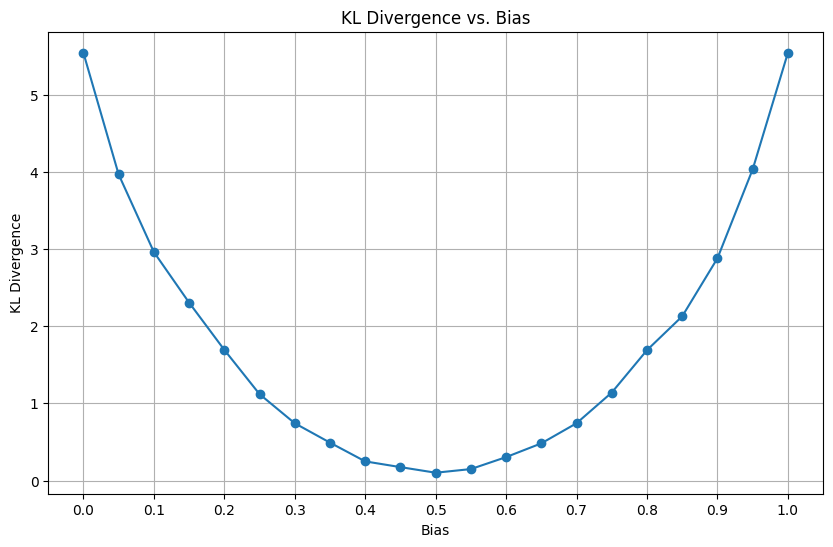

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from google.colab import files

# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(0, 105, 5)]
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate biased binary string using uniform distribution
    binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])

    # Apply the algorithm to get frequencies
    binary_chunks = [binary_string[i:i + 8] for i in range(0, len(binary_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(256)}
    for number in decimal_numbers:
        frequency_dict[number] += 1
    all_frequencies.append(frequency_dict)
df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'


def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    # Add a small epsilon to avoid log(0)
    q = q + np.finfo(float).eps
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Now you can proceed with plotting
plt.figure(figsize=(10, 6))
# Set x-axis ticks with 0.1 intervals
plt.xticks(np.arange(min(df.index), max(df.index) + 0.1, 0.1))
plt.plot(df.index, df['KL Divergence'], marker='o')
plt.xlabel('Bias')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs. Bias')
plt.grid(True)

# Save the plot as a PDF
plot_filename = 'kl_divergence_vs_bias.pdf'
plt.savefig(plot_filename)

# Show the plot
plt.show()

# Download the saved plot file
files.download(plot_filename)

RC4


In [ ]:
!pip install arc4
import os

In [ ]:
import numpy as np
import pandas as pd
from arc4 import ARC4  # Install using: !pip install arc4

def is_prime(n):
  """Checks if a number is prime."""
  if n <= 1:
    return False
  if n <= 3:
    return True
  if n % 2 == 0 or n % 3 == 0:
    return False
  i = 5
  while i * i <= n:
    if n % i == 0 or n % (i + 2) == 0:
      return False
    i += 6
  return True

# Define bias values with 0.05 step
bias_values = [round(i, 2) for i in range(0, 105, 5)]  # Bias from 0.5 to 1.0
bias_values = [i / 100 for i in bias_values]

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate a 10000-bit string using RC4
    key = b'This_is_a_key'  # Replace with a strong key
    cipher = ARC4(key)
    binary_string = ''.join(format(byte, '08b') for byte in cipher.encrypt(os.urandom(1250)))[:10000] # 1250 bytes for 10000 bits

    # Apply bias to the string
    biased_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(len(binary_string))])

    # Apply the algorithm to get frequencies
    binary_chunks = [biased_string[i:i + 8] for i in range(0, len(biased_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(256)}
    for number in decimal_numbers:
        frequency_dict[number] += 1
    all_frequencies.append(frequency_dict)

df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Add prime and composite density columns
prime_counts = []
composite_counts = []
for index in df.index:
  primes = 0
  composites = 0
  for col in df.columns:
    if is_prime(col):
      primes += df.loc[index, col]
    elif col not in (0,1):
      composites += df.loc[index, col]
  prime_counts.append(primes / sum(df.loc[index]))
  composite_counts.append(composites / sum(df.loc[index]))
df['Prime Density'] = prime_counts
df['Composite Density'] = composite_counts

# Display the DataFrame
display(df)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Prime Density,Composite Density
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1250,0.0000,1.0000
0.05,0,0,0,0,0,0,0,0,0,0,...,0,2,2,59,0,48,49,777,0.2104,0.7896
0.10,0,0,0,0,0,0,0,0,0,0,...,0,6,7,62,6,63,50,558,0.2464,0.7536
0.15,0,0,0,0,0,0,0,0,0,0,...,2,8,16,53,9,66,54,360,0.2696,0.7304
0.20,0,0,0,0,0,0,0,1,0,0,...,4,12,11,63,13,44,48,198,0.3072,0.6928
0.25,0,0,0,0,0,0,0,1,0,0,...,6,16,13,33,15,35,38,127,0.2832,0.7168
0.30,0,0,0,1,0,1,1,1,0,2,...,9,13,16,13,6,37,27,71,0.2520,0.7480
0.35,0,1,1,1,1,1,0,1,0,0,...,7,10,11,22,5,23,20,49,0.2520,0.7472
0.40,2,0,2,2,0,1,1,5,2,0,...,5,8,8,14,10,11,14,22,0.2456,0.7528


In [ ]:
import random
import pandas as pd
from google.colab import files
import numpy as np # added this line
from scipy import stats # added this line

def check_randomness(binary_string): # Define check_randomness in this scope
    """Checks randomness of a binary string using Chi-squared test."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]  # Assuming equal probability
    chi2, p = stats.chisquare(observed_frequencies, expected_frequencies)
    return p

#Recalculate p-values as the previous calculation was not correct for this dataframe
p_values = []
for bias in df.index:
  binary_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(10000)])
  p_values.append(check_randomness(binary_string))
df['p-value'] = p_values

# Download the updated DataFrame as a CSV file
df.to_csv('bias_frequencies.csv', index=True)
files.download('bias_frequencies.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-8-17cee44ed034>:16: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-8-17cee44ed034>:16: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


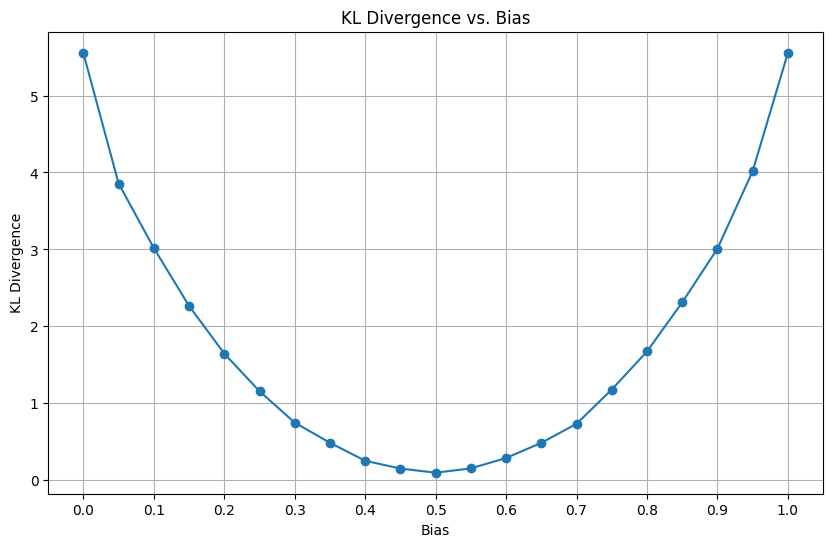

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats # Added this import


# Assuming 'df' is your DataFrame with 'Bias' and 'KL Divergence' columns

# ... (Your previous code) ...


def kl_divergence(p, q):
    """Calculates the Kullback-Leibler (KL) divergence between two distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Calculate KL Divergence for each bias
kl_divergences = []
for bias in df.index:
    # Get observed probabilities from DataFrame for the current bias
    observed_probs = df.loc[bias].values / df.loc[bias].values.sum()

    # Expected probabilities (uniform distribution since total frequency is fixed)
    expected_probs = np.ones_like(observed_probs) / len(observed_probs)

    kl_div = kl_divergence(observed_probs, expected_probs)
    kl_divergences.append(kl_div)

# Add KL Divergence column to DataFrame
df['KL Divergence'] = kl_divergences

# Now you can proceed with plotting
plt.figure(figsize=(10, 6))
# Set x-axis ticks with 0.1 intervals
plt.xticks(np.arange(min(df.index), max(df.index) + 0.1, 0.1))
plt.plot(df.index, df['KL Divergence'], marker='o')
plt.xlabel('Bias')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs. Bias')
plt.grid(True)
plt.show()

In [ ]:
!pip install arc4 cryptography pycryptodome
import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import base64
from google.colab import files  # Import files for download

def generate_binary_string(method, length=1000000):
    """Generates a binary string using the specified method."""
    if method == 'uniform':
        # More efficient way to generate uniform binary string
        random_bits = np.random.randint(0, 2, size=length)
        return ''.join(random_bits.astype(str))
    elif method == 'random':
        return ''.join(np.random.choice(['0', '1'], size=length))
    elif method == 'aes128':
        password = b"password"  # Replace with a strong password
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,  # 16 bytes for 128-bit key
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)  # Raw key, no base64 encoding

        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)  # Generate random IV for each chunk
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]
    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        binary_string = ''.join(format(byte, '08b') for byte in cipher.encrypt(os.urandom(length // 8 + 1)))
        return binary_string[:length]
    else:
        raise ValueError(f"Invalid method: {method}")


def kl_divergence(binary_string):
    """Calculates KL Divergence of a binary string against uniform distribution."""
    observed_probs = [binary_string.count('0') / len(binary_string), binary_string.count('1') / len(binary_string)]
    expected_probs = [0.5, 0.5]
    return stats.entropy(observed_probs, expected_probs)


def chi_squared_test(binary_string):
    """Performs Chi-squared test on a binary string."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p_value = stats.chisquare(observed_frequencies, expected_frequencies)
    return p_value

def runs_test(binary_string):
    """Performs the Runs Test for randomness."""
    runs = 0
    for i in range(len(binary_string) - 1):
        if binary_string[i] != binary_string[i + 1]:
            runs += 1
    n = binary_string.count('1')
    m = binary_string.count('0')
    expected_runs = (2 * n * m) / (n + m) + 1
    variance_runs = (2 * n * m * (2 * n * m - n - m)) / ((n + m)**2 * (n + m - 1))
    z = (runs - expected_runs) / np.sqrt(variance_runs)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-tailed test
    return p_value

# Generate and test with 100 iterations
methods = ['uniform', 'aes128', 'rc4', 'random']
num_iterations = 100
all_results = []  # List to store all results

for method in methods:
    for _ in range(num_iterations):
        binary_string = generate_binary_string(method)
        kl_div = kl_divergence(binary_string)
        p_value_chi2 = chi_squared_test(binary_string)
        p_value_runs = runs_test(binary_string)
        all_results.append({
            'Method': method,
            'KL Divergence': kl_div,
            'Chi-squared p-value': p_value_chi2,
            'Runs Test p-value': p_value_runs
        })

# Create DataFrame
df = pd.DataFrame(all_results)
print(df)

# Download the DataFrame as a CSV file
df.to_csv('randomness_test_results.csv', index=False)
files.download('randomness_test_results.csv')

RC4 - 8 , AES 128 - 8 COMPARISON, ZUC 32.

In [ ]:
# Removed the ZUC import and usage as it's not available in pycryptodome
# !pip install pycryptodome arc4 cryptography
# from Crypto.Cipher import ZUC # ZUC is not available in pycryptodome

!pip install arc4 pycryptodome cryptography # Ensure all necessary libraries are installed

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES # AES is available in pycryptodome
from Crypto.Random import get_random_bytes # get_random_bytes is available in pycryptodome
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import base64
from google.colab import files  # Import files for download

# Removed the generate_binary_string function that included the ZUC method
# We will put the generation logic directly in the loop for the supported methods

def kl_divergence(binary_string):
    """Calculates KL Divergence of a binary string against uniform distribution."""
    # Ensure there are no zero probabilities before calculating log
    count_0 = binary_string.count('0')
    count_1 = binary_string.count('1')
    total_count = len(binary_string)

    # Handle cases where count_0 or count_1 is zero
    if total_count == 0:
        return 0  # Or handle as appropriate for your use case

    prob_0 = count_0 / total_count if count_0 > 0 else 1e-9 # Use a small value instead of 0
    prob_1 = count_1 / total_count if count_1 > 0 else 1e-9 # Use a small value instead of 0

    observed_probs = [prob_0, prob_1]
    expected_probs = [0.5, 0.5]

    # Use scipy.stats.entropy which handles zero probabilities gracefully with a small epsilon
    return stats.entropy(observed_probs, expected_probs)


def chi_squared_test(binary_string):
    """Performs Chi-squared test on a binary string."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]
    # stats.chisquare handles cases where expected frequencies are zero,
    # but it's good practice to ensure observed frequencies are not negative
    # which they won't be in this counting case.
    chi2, p_value = stats.chisquare(observed_frequencies, expected_frequencies)
    return p_value

def runs_test(binary_string):
    """Performs the Runs Test for randomness."""
    if len(binary_string) < 2:
        return 1.0  # Trivial case, perfectly random (or too short to test)

    runs = 1  # Start with at least one run
    for i in range(len(binary_string) - 1):
        if binary_string[i] != binary_string[i + 1]:
            runs += 1

    n0 = binary_string.count('0')
    n1 = binary_string.count('1')
    N = n0 + n1

    if N == 0 or n0 == 0 or n1 == 0:
        return 1.0 # Cannot perform test with only one type of character or empty string

    mean_runs = (2.0 * n0 * n1) / N + 1
    variance_runs = (2.0 * n0 * n1 * (2.0 * n0 * n1 - N)) / (N * N * (N - 1.0))

    # Avoid division by zero if variance is zero (e.g., for very short strings)
    if variance_runs <= 0:
        return 1.0

    z = (runs - mean_runs) / np.sqrt(variance_runs)

    # Calculate the two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return p_value

# Generate and test with 100 iterations
# Removed 'zuc256' from the list of methods
methods = ['uniform', 'aes128', 'rc4', 'random']
num_iterations = 100
all_results = []  # List to store all results
string_length = 1000000 # Using the original length from the previous working cell

for method in methods:
    print(f"Generating and testing strings using {method} method...")
    for i in range(num_iterations):
        try:
            binary_string = ""
            # Generate the binary string based on the method
            if method == 'uniform':
                random_bits = np.random.randint(0, 2, size=string_length)
                binary_string = ''.join(random_bits.astype(str))
            elif method == 'random':
                binary_string = ''.join(np.random.choice(['0', '1'], size=string_length))
            elif method == 'aes128':
                password = b"password"
                salt = os.urandom(16)
                kdf = PBKDF2HMAC(
                    algorithm=hashes.SHA256(),
                    length=16,
                    salt=salt,
                    iterations=100000,
                )
                key = kdf.derive(password)

                bytes_generated = 0
                num_bytes_needed = (string_length + 7) // 8
                while bytes_generated < num_bytes_needed:
                    iv = get_random_bytes(16)
                    cipher = AES.new(key, AES.MODE_CBC, iv)
                    plaintext = get_random_bytes(16)
                    ciphertext = cipher.encrypt(plaintext)
                    binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
                    bytes_generated += len(ciphertext)
                binary_string = binary_string[:string_length] # Trim to desired length

            elif method == 'rc4':
                key = os.urandom(16)
                cipher = ARC4(key)
                num_bytes_needed = (string_length + 7) // 8
                keystream_bytes = cipher.encrypt(os.urandom(num_bytes_needed))
                binary_string = ''.join(format(byte, '08b') for byte in keystream_bytes)
                binary_string = binary_string[:string_length] # Trim to desired length

            # Now perform the tests on the generated string
            kl_div = kl_divergence(binary_string)
            p_value_chi2 = chi_squared_test(binary_string)
            p_value_runs = runs_test(binary_string)

            all_results.append({
                'Method': method,
                'Iteration': i + 1,
                'KL Divergence': kl_div,
                'Chi-squared p-value': p_value_chi2,
                'Runs Test p-value': p_value_runs
            })
        except Exception as e:
            print(f"Error generating/testing string for method {method}, iteration {i+1}: {e}")


# Create DataFrame
df = pd.DataFrame(all_results)
print("\nResults DataFrame:")
print(df)

# Download the DataFrame as a CSV file
try:
    df.to_csv('randomness_test_results.csv', index=False)
    files.download('randomness_test_results.csv')
    print("\nCSV file downloaded successfully.")
except Exception as e:
     print(f"\nError downloading CSV file: {e}")

Generating and testing strings using uniform method...
Generating and testing strings using aes128 method...
Generating and testing strings using rc4 method...
Generating and testing strings using random method...

Results DataFrame:
      Method  Iteration  KL Divergence  Chi-squared p-value  Runs Test p-value
0    uniform          1   2.492180e-07             0.480188           0.369986
1    uniform          2   8.738423e-07             0.186168           0.419235
2    uniform          3   1.860500e-07             0.541862           0.357378
3    uniform          4   1.176578e-06             0.125030           0.103599
4    uniform          5   2.247200e-08             0.832107           0.963346
..       ...        ...            ...                  ...                ...
395   random         96   3.698000e-09             0.931466           0.241998
396   random         97   1.241889e-06             0.115026           0.827806
397   random         98   2.289802e-06             0.03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


CSV file downloaded successfully.


In [ ]:
from Crypto.Cipher import ChaCha20
from Crypto.Random import get_random_bytes
import numpy as np
import os
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from Crypto.Cipher import AES, ARC4

def generate_binary_string(method, length=12800):
    if method == 'uniform':
        random_bits = np.random.randint(0, 2, size=length)
        return ''.join(random_bits.astype(str))
    elif method == 'random':
        return ''.join(np.random.choice(['0', '1'], size=length))
    elif method == 'aes128':
        password = b"password"  # Replace with a secure password
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]
    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4.new(key)
        binary_string = ''.join(format(byte, '08b') for byte in cipher.encrypt(os.urandom(length // 8 + 1)))
        return binary_string[:length]
    elif method == 'chacha20':
        key = get_random_bytes(32)
        nonce = get_random_bytes(8)
        cipher = ChaCha20.new(key=key, nonce=nonce)
        stream = cipher.encrypt(b'\x00' * (length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in stream)[:length]
    else:
        raise ValueError(f"Invalid method: {method}")


In [ ]:

import random
def is_prime(n):
  """Checks if a number is prime."""
  if n <= 1:
    return False
  if n <= 3:
    return True
  if n % 2 == 0 or n % 3 == 0:
    return False
  i = 5
  while i * i <= n:
    if n % i == 0 or n % (i + 2) == 0:
      return False
    i += 6
  return True

def calculate_prime_density(binary_string):
    """Calculates the density of prime numbers in 8-bit chunks."""
    binary_chunks = [binary_string[i:i + 8] for i in range(0, len(binary_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    prime_count = sum(1 for num in decimal_numbers if is_prime(num))
    return prime_count / len(decimal_numbers) if len(decimal_numbers) > 0 else 0

def calculate_composite_density(binary_string):
    """Calculates the density of composite numbers in 8-bit chunks."""
    binary_chunks = [binary_string[i:i + 8] for i in range(0, len(binary_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    composite_count = sum(1 for num in decimal_numbers if not is_prime(num) and num > 1)
    return composite_count / len(decimal_numbers) if len(decimal_numbers) > 0 else 0

def kl_divergence_binary(binary_string):
    """Calculates KL Divergence of a binary string against uniform distribution."""
    count_0 = binary_string.count('0')
    count_1 = binary_string.count('1')
    total_count = len(binary_string)

    if total_count == 0:
        return 0

    prob_0 = count_0 / total_count if count_0 > 0 else 1e-9
    prob_1 = count_1 / total_count if count_1 > 0 else 1e-9

    observed_probs = [prob_0, prob_1]
    expected_probs = [0.5, 0.5]

    return stats.entropy(observed_probs, expected_probs)

def chi_squared_test_binary(binary_string):
    """Performs Chi-squared test on a binary string."""
    observed_frequencies = [binary_string.count('0'), binary_string.count('1')]
    expected_frequencies = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p_value = stats.chisquare(observed_frequencies, expected_frequencies)
    return p_value

# Generate a 12800-bit binary string using a simple random choice for this example
string_length = 12800
binary_string = ''.join(random.choices(['0', '1'], k=string_length))

# Calculate metrics
prime_density = calculate_prime_density(binary_string)
composite_density = calculate_composite_density(binary_string)
kl_div = kl_divergence_binary(binary_string)
p_value_chi2 = chi_squared_test_binary(binary_string)

print(f"Generated binary string of length: {len(binary_string)}")
print(f"Prime Density (8-bit chunks): {prime_density:.4f}")
print(f"Composite Density (8-bit chunks): {composite_density:.4f}")
print(f"KL Divergence (against uniform): {kl_div:.4f}")
print(f"Chi-squared p-value: {p_value_chi2:.4f}")


Generated binary string of length: 12800
Prime Density (8-bit chunks): 0.2000
Composite Density (8-bit chunks): 0.7906
KL Divergence (against uniform): 0.0000
Chi-squared p-value: 0.8458


In [ ]:
!pip install arc4 cryptography pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab import files

class ZUC256:
    def __init__(self, key, iv):
        self.key = key
        self.iv = iv
        self.state = np.frombuffer(key[:16], dtype=np.uint8).tolist()
        self.counter = 0

    def _dummy_keystream_word(self):
        # Pseudo stream generator for simulation: rotates and mixes key + IV + counter
        mix = (self.key[self.counter % len(self.key)] ^
               self.iv[self.counter % len(self.iv)] ^
               self.counter) & 0xFF
        word = (mix << 24) | (mix << 16) | (mix << 8) | mix
        self.counter += 1
        return word

    def generate_keystream(self, num_words):
        return [self._dummy_keystream_word() for _ in range(num_words)]

def generate_binary_string(method, length=1000000):
    """Generates a binary string using the specified method."""
    if method == 'uniform':
        random_bits = np.random.randint(0, 2, size=length)
        return ''.join(random_bits.astype(str))
    elif method == 'random':
        return ''.join(np.random.choice(['0', '1'], size=length))
    elif method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]
    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        binary_string = ''.join(format(byte, '08b') for byte in cipher.encrypt(os.urandom(length // 8 + 1)))
        return binary_string[:length]
    elif method == 'zuc256_32bit':
        key = os.urandom(32)
        iv = os.urandom(25)
        zuc = ZUC256(key, iv)
        num_words = (length + 31) // 32
        stream = zuc.generate_keystream(num_words)
        binary_string = ''.join(format(word, '032b') for word in stream)
        return binary_string[:length]
    else:
        raise ValueError(f"Invalid method: {method}")


def kl_divergence(binary_string):
    observed_probs = [binary_string.count('0') / len(binary_string), binary_string.count('1') / len(binary_string)]
    expected_probs = [0.5, 0.5]
    return stats.entropy(observed_probs, expected_probs)

def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p_value = stats.chisquare(observed, expected)
    return p_value

def runs_test(binary_string):
    runs = 1
    for i in range(1, len(binary_string)):
        if binary_string[i] != binary_string[i - 1]:
            runs += 1
    n = binary_string.count('1')
    m = binary_string.count('0')
    expected_runs = (2 * n * m) / (n + m) + 1
    variance_runs = (2 * n * m * (2 * n * m - n - m)) / ((n + m)**2 * (n + m - 1))
    z = (runs - expected_runs) / np.sqrt(variance_runs)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return p_value


methods = ['uniform', 'aes128', 'rc4', 'random', 'zuc256_32bit']
num_iterations = 100
length = 1000000  # 1 million bits

results = []

for method in methods:
    for _ in range(num_iterations):
        binary_string = generate_binary_string(method, length)
        kl = kl_divergence(binary_string)
        chi2 = chi_squared_test(binary_string)
        runs = runs_test(binary_string)
        results.append({
            'Method': method,
            'KL Divergence': kl,
            'Chi-squared p-value': chi2,
            'Runs Test p-value': runs
        })

# Save results
df = pd.DataFrame(results)
df.to_csv('randomness_test_results_with_zuc.csv', index=False)
files.download('randomness_test_results_with_zuc.csv')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import os
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes

def generate_binary_string(method, length=1000000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        # Simulate ZUC by generating 32-bit blocks and concatenating
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

def prime_composite_density(binary_string):
    def is_prime(n):
        if n < 2: return False
        for i in range(2, int(n**0.5) + 1):
            if n % i == 0: return False
        return True

    primes = 0
    composites = 0
    for i in range(0, len(binary_string) - 7, 8):
        byte = int(binary_string[i:i+8], 2)
        if byte == 0 or byte == 1:
            continue
        if is_prime(byte):
            primes += 1
        else:
            composites += 1
    total = primes + composites
    return primes / total if total else 0, composites / total if total else 0

# Run for each method
methods = ['aes128', 'rc4', 'zuc32']
results = []

for method in methods:
    binary = generate_binary_string(method)
    kl = kl_divergence(binary)
    chi = chi_squared_test(binary)
    runs = runs_test(binary)
    prime_dens, comp_dens = prime_composite_density(binary)

    results.append({
        "Method": method,
        "String Length": len(binary),
        "KL Divergence": kl,
        "Chi-squared p-value": chi,
        "Runs Test p-value": runs,
        "Prime Density (8-bit)": prime_dens,
        "Composite Density (8-bit)": comp_dens
    })

df = pd.DataFrame(results)
pd.set_option('display.float_format', lambda x: f'{x:.8f}')
print(df)


   Method  String Length  KL Divergence  Chi-squared p-value  \
0  aes128        1000000     0.00000009           0.66865112   
1     rc4        1000000     0.00000055           0.29371811   
2   zuc32        1000000     0.00000115           0.13002584   

   Runs Test p-value  Prime Density (8-bit)  Composite Density (8-bit)  
0         0.66997416             0.21270594                 0.78729406  
1         0.25465964             0.21225309                 0.78774691  
2         0.96148327             0.21176992                 0.78823008  


In [ ]:
!pip install arc4 cryptography pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab import files

def generate_binary_string(method, length=1000000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

def prime_composite_density(binary_string):
    def is_prime(n):
        if n < 2: return False
        for i in range(2, int(n**0.5) + 1):
            if n % i == 0: return False
        return True

    primes = 0
    composites = 0
    for i in range(0, len(binary_string) - 15, 16):  # 16-bit chunks
        word = int(binary_string[i:i+16], 2)
        if word == 0 or word == 1:
            continue
        if is_prime(word):
            primes += 1
        else:
            composites += 1
    total = primes + composites
    return primes / total if total else 0, composites / total if total else 0

# Run 100 observations per method
methods = ['aes128', 'rc4', 'zuc32']
num_observations = 100
all_results = []

for method in methods:
    for i in range(num_observations):
        binary = generate_binary_string(method)
        kl = kl_divergence(binary)
        chi = chi_squared_test(binary)
        runs = runs_test(binary)
        prime_dens, comp_dens = prime_composite_density(binary)

        all_results.append({
            "Method": method,
            "String Length": len(binary),
            "KL Divergence": kl,
            "Chi-squared p-value": chi,
            "Runs Test p-value": runs,
            "Prime Density (16-bit)": prime_dens,
            "Composite Density (16-bit)": comp_dens
        })
df = pd.DataFrame(all_results)
df.to_csv("randomness_test_results.csv", index=False)
files.download("randomness_test_results.csv")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
from arc4 import ARC4  # Install using: !pip install arc4

# Generate list of prime squares up to 255
def generate_prime_squares(limit=255):
    def is_prime(n):
        if n <= 1: return False
        if n <= 3: return True
        if n % 2 == 0 or n % 3 == 0: return False
        i = 5
        while i * i <= n:
            if n % i == 0 or n % (i + 2) == 0:
                return False
            i += 6
        return True
    primes = [i for i in range(2, int(limit**0.5) + 1) if is_prime(i)]
    return set(p**2 for p in primes if p**2 <= limit)

# Get all prime squares under 256
prime_squares = generate_prime_squares()

# Define bias values with 0.05 step
bias_values = [i / 100 for i in range(0, 105, 5)]  # Bias from 0.0 to 1.0

# Store frequencies for each bias
all_frequencies = []

for bias in bias_values:
    # Generate a 10000-bit string using RC4
    key = b'This_is_a_key'
    cipher = ARC4(key)
    binary_string = ''.join(format(byte, '08b') for byte in cipher.encrypt(os.urandom(1250)))[:10000]

    # Apply bias to the string
    biased_string = ''.join(['0' if np.random.uniform() < bias else '1' for _ in range(len(binary_string))])

    # Convert to 8-bit chunks and count frequency
    binary_chunks = [biased_string[i:i + 8] for i in range(0, len(biased_string), 8)]
    decimal_numbers = [int(chunk, 2) for chunk in binary_chunks]
    frequency_dict = {i: 0 for i in range(256)}
    for number in decimal_numbers:
        frequency_dict[number] += 1
    all_frequencies.append(frequency_dict)

# Create DataFrame from frequencies
df = pd.DataFrame(all_frequencies, index=bias_values)
df.index.name = 'Bias'

# Calculate prime square density and other density
prime_sq_density = []
other_density = []

for index in df.index:
    total = sum(df.loc[index])
    psq = sum(df.loc[index, val] for val in prime_squares)
    other = total - psq - df.loc[index, 0] - df.loc[index, 1]
    prime_sq_density.append(psq / total)
    other_density.append(other / total)

df['Prime Square Density'] = prime_sq_density
df['Other Density'] = other_density

# Display the updated DataFrame
display(df)


,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Prime Square Density,Other Density
Bias,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1250,0.0000,1.0000
0.05,0,0,0,0,0,0,0,0,0,0,...,0,0,2,51,4,36,43,824,0.0000,1.0000
0.10,0,0,0,0,0,0,0,0,0,0,...,0,10,1,58,3,53,54,548,0.0000,1.0000
0.15,0,0,0,0,0,0,0,0,0,0,...,3,7,11,56,14,47,71,326,0.0024,0.9976
0.20,0,0,0,1,0,0,0,0,0,0,...,3,20,20,51,15,47,59,207,0.0056,0.9944
0.25,0,0,0,0,0,0,0,1,0,0,...,2,8,10,48,19,54,39,115,0.0032,0.9968
0.30,0,2,1,0,0,0,1,1,0,0,...,4,12,7,31,11,29,45,64,0.0064,0.9920
0.35,1,0,0,1,0,2,0,4,1,0,...,12,5,16,32,13,24,15,37,0.0168,0.9824
0.40,0,1,1,4,1,1,0,3,2,2,...,10,8,8,10,11,9,15,16,0.0152,0.9840


In [ ]:
!pip install arc4 cryptography pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab import files

# Generate binary string from cipher
def generate_binary_string(method, length=1000000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

# KL Divergence from uniform
def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

# Chi-squared test
def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

# Runs test
def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

# Prime square density function
def prime_square_density(binary_string):
    # Precompute prime squares up to 65536 (max 16-bit value)
    def generate_prime_squares(limit):
        sieve = [True] * (int(limit**0.5) + 1)
        sieve[0:2] = [False, False]
        for i in range(2, int(len(sieve)**0.5) + 1):
            if sieve[i]:
                for j in range(i*i, len(sieve), i):
                    sieve[j] = False
        primes = [i for i, is_prime in enumerate(sieve) if is_prime]
        return {p*p for p in primes if p*p < 2**16}

    prime_squares = generate_prime_squares(2**16)
    prime_sq_count = 0
    other_count = 0

    for i in range(0, len(binary_string) - 15, 16):
        val = int(binary_string[i:i+16], 2)
        if val in prime_squares:
            prime_sq_count += 1
        else:
            other_count += 1

    total = prime_sq_count + other_count
    return prime_sq_count / total if total else 0, other_count / total if total else 0

# Run tests and collect data
methods = ['aes128', 'rc4', 'zuc32']
num_observations = 100
all_results = []

for method in methods:
    for i in range(num_observations):
        binary = generate_binary_string(method)
        kl = kl_divergence(binary)
        chi = chi_squared_test(binary)
        runs = runs_test(binary)
        prime_sq_dens, other_dens = prime_square_density(binary)

        all_results.append({
            "Method": method,
            "String Length": len(binary),
            "KL Divergence": kl,
            "Chi-squared p-value": chi,
            "Runs Test p-value": runs,
            "Prime Square Density (16-bit)": prime_sq_dens,
            "Other Density (16-bit)": other_dens
        })

# Save results
df = pd.DataFrame(all_results)
df.to_csv("prime_square_randomness_results.csv", index=False)
files.download("prime_square_randomness_results.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install arc4 cryptography pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab import files

# Generate binary string from cipher
def generate_binary_string(method, length=1000000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

# KL Divergence from uniform
def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

# Chi-squared test
def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

# Runs test
def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

# Prime product density (16-bit chunks)
def prime_product_density(binary_string):
    def generate_prime_products(limit=256):
        # Generate all products of two distinct primes below the limit
        sieve = [True] * limit
        sieve[0:2] = [False, False]
        for i in range(2, int(limit**0.5) + 1):
            if sieve[i]:
                for j in range(i*i, limit, i):
                    sieve[j] = False
        primes = [i for i, is_prime in enumerate(sieve) if is_prime]
        prime_products = set()
        for i in range(len(primes)):
            for j in range(i + 1, len(primes)):
                product = primes[i] * primes[j]
                if product < 2**16:
                    prime_products.add(product)
        return prime_products

    prime_products = generate_prime_products()
    prime_prod_count = 0
    other_count = 0

    for i in range(0, len(binary_string) - 15, 16):
        val = int(binary_string[i:i+16], 2)
        if val in prime_products:
            prime_prod_count += 1
        else:
            other_count += 1

    total = prime_prod_count + other_count
    return prime_prod_count / total if total else 0, other_count / total if total else 0

# Run tests and collect data
methods = ['aes128', 'rc4', 'zuc32']
num_observations = 100
all_results = []

for method in methods:
    for i in range(num_observations):
        binary = generate_binary_string(method)
        kl = kl_divergence(binary)
        chi = chi_squared_test(binary)
        runs = runs_test(binary)
        prime_prod_dens, other_dens = prime_product_density(binary)

        all_results.append({
            "Method": method,
            "String Length": len(binary),
            "KL Divergence": kl,
            "Chi-squared p-value": chi,
            "Runs Test p-value": runs,
            "Prime Product Density (16-bit)": prime_prod_dens,
            "Other Density (16-bit)": other_dens
        })

# Save results
df = pd.DataFrame(all_results)
df.to_csv("prime_product_randomness_results.csv", index=False)
files.download("prime_product_randomness_results.csv")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install arc4 cryptography pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab import files

# Binary generator
def generate_binary_string(method, length=1000000):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        encrypted = cipher.encrypt(os.urandom(length // 8 + 1))
        return ''.join(format(byte, '08b') for byte in encrypted)[:length]

    elif method == 'zuc32':
        binary_string = ''
        for _ in range(length // 32):
            block = np.random.randint(0, 2, 32)
            binary_string += ''.join(block.astype(str))
        return binary_string[:length]

    else:
        raise ValueError("Unsupported method")

# Statistical tests
def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

# Prime sets
def generate_prime_data(limit=65536):
    sieve = [True] * limit
    sieve[0:2] = [False, False]
    for i in range(2, int(limit ** 0.5) + 1):
        if sieve[i]:
            for j in range(i*i, limit, i):
                sieve[j] = False
    primes = [i for i, is_prime in enumerate(sieve) if is_prime]
    prime_set = set(primes)
    prime_square_set = {p*p for p in primes if p*p < limit}
    prime_product_set = set()
    for i in range(len(primes)):
        for j in range(i+1, len(primes)):
            prod = primes[i] * primes[j]
            if prod < limit:
                prime_product_set.add(prod)
    return prime_set, prime_square_set, prime_product_set

prime_set, prime_square_set, prime_product_set = generate_prime_data()

# Density test
def compute_density(binary_string, target_set):
    match = other = 0
    for i in range(0, len(binary_string) - 15, 16):
        val = int(binary_string[i:i+16], 2)
        if val in target_set:
            match += 1
        else:
            other += 1
    total = match + other
    return match / total if total else 0, other / total if total else 0

# Main experiment
methods = ['aes128', 'rc4', 'zuc32']
num_observations = 100
all_results = []

for method in methods:
    for _ in range(num_observations):
        bin_str = generate_binary_string(method)

        # Prime
        prime_density, prime_other = compute_density(bin_str, prime_set)
        kl_prime = kl_divergence(bin_str)
        chi_prime = chi_squared_test(bin_str)
        runs_prime = runs_test(bin_str)

        # Prime square
        square_density, square_other = compute_density(bin_str, prime_square_set)
        kl_square = kl_divergence(bin_str)
        chi_square = chi_squared_test(bin_str)
        runs_square = runs_test(bin_str)

        # Prime product
        product_density, product_other = compute_density(bin_str, prime_product_set)
        kl_product = kl_divergence(bin_str)
        chi_product = chi_squared_test(bin_str)
        runs_product = runs_test(bin_str)

        all_results.append({
            "Method": method,
            "Prime Density": prime_density,
            "Prime Other": prime_other,
            "KL Prime": kl_prime,
            "Chi Prime": chi_prime,
            "Runs Prime": runs_prime,

            "Prime Square Density": square_density,
            "Prime Square Other": square_other,
            "KL Square": kl_square,
            "Chi Square": chi_square,
            "Runs Square": runs_square,

            "Prime Product Density": product_density,
            "Prime Product Other": product_other,
            "KL Product": kl_product,
            "Chi Product": chi_product,
            "Runs Product": runs_product
        })

# Save
df = pd.DataFrame(all_results)
df.to_csv("full_randomness_comparison.csv", index=False)
files.download("full_randomness_comparison.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Specified total number of 0 and 1 using specified AES and RC4


In [ ]:
!pip install pycryptodome arc4 cryptography

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from arc4 import ARC4
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import base64
from google.colab import files # Import files for download

def generate_binary_string(method, length=1000000):
    """
    Generates a binary string of a specified length using the given method.
    Aims for a near 50/50 distribution of 0s and 1s.
    """
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)

        bytes_needed = (length + 7) // 8
        generated_bytes = b''
        chunk_size_bytes = 1024 * 16 # 16 KB chunks
        while len(generated_bytes) < bytes_needed:
            current_chunk_bytes_needed = min(chunk_size_bytes, bytes_needed - len(generated_bytes))
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext_size = ((current_chunk_bytes_needed + 15) // 16) * 16
            plaintext = get_random_bytes(plaintext_size)
            ciphertext = cipher.encrypt(plaintext)
            generated_bytes += ciphertext

        binary_string = ''.join(format(byte, '08b') for byte in generated_bytes)
        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4(key)
        bytes_needed = (length + 7) // 8
        chunk_size_bytes = 1024 * 16 # 16 KB chunks
        generated_bytes = b''
        while len(generated_bytes) < bytes_needed:
             current_chunk_bytes_needed = min(chunk_size_bytes, bytes_needed - len(generated_bytes))
             generated_bytes += cipher.encrypt(os.urandom(current_chunk_bytes_needed))

        binary_string = ''.join(format(byte, '08b') for byte in generated_bytes)
        return binary_string[:length]

    elif method == 'zuc32':
        # Simulate ZUC32 by generating blocks of 32 random bits
        # This is NOT a true ZUC implementation.
        binary_string = ''
        num_bits_generated = 0
        while num_bits_generated < length:
             bits_to_generate = min(32, length - num_bits_generated)
             block = np.random.randint(0, 2, bits_to_generate)
             binary_string += ''.join(block.astype(str))
             num_bits_generated += bits_to_generate
        return binary_string[:length]

    else:
        raise ValueError(f"Invalid method: {method}")

# --- Implementations of Basic NIST-like Tests ---
# (Keep the existing implementations of frequency_test, runs_test, longest_run_of_ones_test,
#  approximate_entropy_test, and serial_test as they were updated in the previous step)

def frequency_test(binary_string):
    """
    Frequency Test (Monobit Test) - Checks if the number of 0s and 1s is approximately equal.
    Returns the p-value.
    """
    n = len(binary_string)
    n0 = binary_string.count('0')
    n1 = binary_string.count('1')

    if n == 0:
        return 0.0

    s_obs = abs(n1 - n/2) / np.sqrt(n/4) if n > 0 else 0
    p_value = stats.norm.sf(s_obs) * 2

    return p_value

def runs_test(binary_string):
    """
    Runs Test - Checks the number of runs of consecutive identical bits.
    Returns the p-value.
    """
    n = len(binary_string)
    n0 = binary_string.count('0')
    n1 = binary_string.count('1')

    if n0 == 0 or n1 == 0 or n < 2:
        return 0.0

    runs = 1
    for i in range(n - 1):
        if binary_string[i] != binary_string[i + 1]:
            runs += 1

    expected_runs = (2.0 * n0 * n1) / n + 1
    variance_runs = (2.0 * n0 * n1 * (2.0 * n0 * n1 - n)) / (n * n * (n - 1.0))

    if variance_runs <= 0:
        return 0.0

    z = (runs - expected_runs) / np.sqrt(variance_runs)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return p_value

def longest_run_of_ones_test(binary_string):
    """
    Longest Run of Ones Test - Checks the length of the longest run of ones.
    Returns the longest run length and a note about p-value calculation.
    A full NIST implementation is needed for a proper p-value.
    """
    n = len(binary_string)
    if n == 0:
        return 0, "String is empty"

    max_run = 0
    current_run = 0
    for bit in binary_string:
        if bit == '1':
            current_run += 1
            max_run = max(max_run, current_run)
        else:
            current_run = 0

    return max_run, "Requires NIST critical values for proper p-value for this length"

def approximate_entropy_test(binary_string, m=10):
    """
    Approximate Entropy Test - Checks the randomness based on the frequency of
    overlapping blocks of two consecutive lengths (m and m+1).
    Returns the p-value.
    Simplified implementation for demonstration.
    """
    n = len(binary_string)
    m = 10 # Using 10 for demonstration with 1M bits.

    if n < m + 2:
        print(f"Warning: String length ({n}) is too short for Approximate Entropy Test with m={m}.")
        return 0.0

    def _get_counts(string, k, length):
        freq = {}
        padded_string = string + string[:k-1]
        for i in range(length):
            block = padded_string[i : i + k]
            freq[block] = freq.get(block, 0) + 1
        return freq

    def _calculate_phi(counts, length):
        sum_log_freq = 0
        for count in counts.values():
            prob = count / length
            if prob > 0:
                 sum_log_freq += prob * np.log(prob)
        return sum_log_freq

    counts_m = _get_counts(binary_string, m, n)
    counts_m_plus_1 = _get_counts(binary_string, m + 1, n)

    phi_m = _calculate_phi(counts_m, n)
    phi_m_plus_1 = _calculate_phi(counts_m_plus_1, n)

    apen = phi_m - phi_m_plus_1

    chi2_approx = 2 * n * apen
    df = 2**m - 1

    try:
         p_value = 1 - stats.chi2.cdf(max(0, chi2_approx), df) if df > 0 else 0.0
    except ValueError:
         p_value = 0.0

    return p_value

def serial_test(binary_string, m=9):
    """
    Serial Test - Checks the frequency of all possible overlapping blocks of length m.
    Returns the p-values for two related statistics.
    Simplified implementation for demonstration (m=9 for 1M bits).
    """
    n = len(binary_string)
    m = 9 # Using 9 for demonstration with 1M bits.

    if n < m:
         print(f"Warning: String length ({n}) is too short for Serial Test with m={m}.")
         return 0.0, 0.0

    def _psi_squared(string, k, length):
        if k == 0:
            return 0
        if length < k:
             return 0

        freq = {}
        padded_string = string + string[:k-1]
        for i in range(length):
            block = padded_string[i : i + k]
            freq[block] = freq.get(block, 0) + 1

        sum_sq_freq = sum(count**2 for count in freq.values())
        psi_sq = (sum_sq_freq * (2**k) / length) - length

        return psi_sq

    psi_sq_m = _psi_squared(binary_string, m, n)
    psi_sq_m_minus_1 = _psi_squared(binary_string, m - 1, n) if m >= 1 else 0
    psi_sq_m_minus_2 = _psi_squared(binary_string, m - 2, n) if m >= 2 else 0

    chi2_1 = psi_sq_m - psi_sq_m_minus_1
    df1 = 2**(m - 1)

    if m == 1:
         chi2_2 = psi_sq_m - 2 * psi_sq_m_minus_1
         df2 = 0
    elif m == 2:
         chi2_2 = psi_sq_m - 2 * psi_sq_m_minus_1 + psi_sq_m_minus_2
         df2 = 2**(m-2)
    else:
         chi2_2 = psi_sq_m - 2 * psi_sq_m_minus_1 + psi_sq_m_minus_2
         df2 = 2**(m - 2)

    p_value1 = 1 - stats.chi2.cdf(max(0, chi2_1), df1) if df1 > 0 and chi2_1 >= 0 else 0.0
    p_value2 = 1 - stats.chi2.cdf(max(0, chi2_2), df2) if df2 > 0 and chi2_2 >= 0 else 0.0

    return p_value1, p_value2

# --- Perform Simulations and Collect Data ---

string_length = 1000000 # Set the desired string length
num_simulations = 100   # Set the number of simulations per method
methods_to_test = ['aes128', 'rc4', 'zuc32']
all_results = [] # List to store results from all simulations

print(f"Starting {num_simulations} simulations for each method with string length {string_length}...")

for method in methods_to_test:
    print(f"\nTesting method: {method}")
    for i in range(num_simulations):
        print(f"  Simulation {i+1}/{num_simulations}...")
        try:
            binary_string = generate_binary_string(method, string_length)

            freq_p = frequency_test(binary_string)
            runs_p = runs_test(binary_string)
            longest_run, longest_run_note = longest_run_of_ones_test(binary_string)
            # Choose m values appropriate for N=1,000,000 based on NIST recommendations
            # m=10 for APEN and m=9 for Serial are reasonable compromises for demonstration speed vs test strength.
            apen_p = approximate_entropy_test(binary_string, m=10)
            serial_p1, serial_p2 = serial_test(binary_string, m=9)

            # Append results as a dictionary
            all_results.append({
                "Method": method,
                "Simulation": i + 1,
                "String Length": string_length,
                "Frequency Test p-value": freq_p,
                "Runs Test p-value": runs_p,
                "Longest Run of Ones": longest_run,
                "Approximate Entropy Test (m=10) p-value": apen_p,
                "Serial Test (m=9) p-value 1": serial_p1,
                "Serial Test (m=9) p-value 2": serial_p2,
                # Include the longest_run_note if needed, but maybe too verbose for CSV
                # "Longest Run Note": longest_run_note
            })
        except Exception as e:
            print(f"  Error during simulation {i+1} for method {method}: {e}")
            # Optionally, append an entry with error information
            all_results.append({
                "Method": method,
                "Simulation": i + 1,
                "String Length": string_length,
                "Error": str(e)
                # Fill other fields with None or NaN if desired
            })


# Create DataFrame from results
df = pd.DataFrame(all_results)

# Display the first few rows and info
print("\n--- Results DataFrame ---")
print(df.head())
print("\nDataFrame Info:")
df.info()

# Save DataFrame to CSV
csv_filename = "randomness_simulation_results.csv"
df.to_csv(csv_filename, index=False)

print(f"\nResults saved to {csv_filename}")

# Download the CSV file (for Google Colab)
try:
    files.download(csv_filename)
    print(f"{csv_filename} downloaded successfully.")
except Exception as e:
    print(f"Error downloading {csv_filename}: {e}")

Starting 100 simulations for each method with string length 1000000...

Testing method: aes128
  Simulation 1/100...
  Simulation 2/100...
  Simulation 3/100...
  Simulation 4/100...
  Simulation 5/100...
  Simulation 6/100...
  Simulation 7/100...
  Simulation 8/100...
  Simulation 9/100...
  Simulation 10/100...
  Simulation 11/100...
  Simulation 12/100...
  Simulation 13/100...
  Simulation 14/100...
  Simulation 15/100...
  Simulation 16/100...
  Simulation 17/100...
  Simulation 18/100...
  Simulation 19/100...
  Simulation 20/100...
  Simulation 21/100...
  Simulation 22/100...
  Simulation 23/100...
  Simulation 24/100...
  Simulation 25/100...
  Simulation 26/100...
  Simulation 27/100...
  Simulation 28/100...
  Simulation 29/100...
  Simulation 30/100...
  Simulation 31/100...
  Simulation 32/100...
  Simulation 33/100...
  Simulation 34/100...
  Simulation 35/100...
  Simulation 36/100...
  Simulation 37/100...
  Simulation 38/100...
  Simulation 39/100...
  Simulation 40/1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

randomness_simulation_results.csv downloaded successfully.


In [ ]:
import os
import csv
from Crypto.Cipher import AES, ARC4
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC

def generate_binary_string(method, length):
    """Generates a binary string of specified length using AES-128 or RC4."""
    if method == 'aes128':
        password = b"strong_password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=10000000,
        )
        key = kdf.derive(password)

        binary_string = ""
        block_size_bits = 128
        blocks_needed = (length + block_size_bits - 1) // block_size_bits

        for _ in range(blocks_needed):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(b, '08b') for b in ciphertext)
            if len(binary_string) >= length:
                break

        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4.new(key)
        num_bytes = (length + 7) // 8
        keystream = cipher.encrypt(os.urandom(num_bytes))
        return ''.join(format(b, '08b') for b in keystream)[:length]

    else:
        raise ValueError("Unsupported method")

def count_consecutive_runs(binary_string, digit='1', min_run=20):
    """Counts how many runs of at least `min_run` consecutive `digit` occur."""
    count = 0
    current_run = 0
    for bit in binary_string:
        if bit == digit:
            current_run += 1
        else:
            if current_run >= min_run:
                count += 1
            current_run = 0
    if current_run >= min_run:
        count += 1
    return count

# Configurations
methods = ['aes128', 'rc4']
simulations = 20
string_length = 100_000_000  # 100 million bits
min_run_length = 20
output_file = 'aes_rc4_comparison.csv'

# CSV setup
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Simulation", "Method", f"Consecutive 1s (≥{min_run_length})", f"Consecutive 0s (≥{min_run_length})"])

    for sim in range(1, simulations + 1):
        print(f"\nSimulation {sim}/{simulations}")
        for method in methods:
            print(f"  Generating {string_length} bits using {method}...")
            binary = generate_binary_string(method, string_length)
            ones = count_consecutive_runs(binary, '1', min_run=min_run_length)
            zeros = count_consecutive_runs(binary, '0', min_run=min_run_length)
            writer.writerow([sim, method, ones, zeros])
            print(f"    {method}: 1s ≥{min_run_length} = {ones}, 0s ≥{min_run_length} = {zeros}")

print(f"\n✅ All simulations complete. Results saved to '{output_file}'")



Simulation 1/20
  Generating 100000000 bits using aes128...
    aes128: 1s ≥20 = 48, 0s ≥20 = 46
  Generating 100000000 bits using rc4...
    rc4: 1s ≥20 = 52, 0s ≥20 = 61

Simulation 2/20
  Generating 100000000 bits using aes128...
    aes128: 1s ≥20 = 35, 0s ≥20 = 56
  Generating 100000000 bits using rc4...
    rc4: 1s ≥20 = 42, 0s ≥20 = 50

Simulation 3/20
  Generating 100000000 bits using aes128...
    aes128: 1s ≥20 = 65, 0s ≥20 = 42
  Generating 100000000 bits using rc4...
    rc4: 1s ≥20 = 53, 0s ≥20 = 64

Simulation 4/20
  Generating 100000000 bits using aes128...
    aes128: 1s ≥20 = 45, 0s ≥20 = 53
  Generating 100000000 bits using rc4...
    rc4: 1s ≥20 = 50, 0s ≥20 = 33

Simulation 5/20
  Generating 100000000 bits using aes128...
    aes128: 1s ≥20 = 50, 0s ≥20 = 45
  Generating 100000000 bits using rc4...
    rc4: 1s ≥20 = 52, 0s ≥20 = 49

Simulation 6/20
  Generating 100000000 bits using aes128...
    aes128: 1s ≥20 = 54, 0s ≥20 = 51
  Generating 100000000 bits using rc4

In [ ]:
import os
import csv
from Crypto.Cipher import AES, ARC4
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC

def generate_binary_string(method, length):
    if method == 'aes128':
        password = b"strong_password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)

        binary_string = ""
        block_size_bits = 128
        blocks_needed = (length + block_size_bits - 1) // block_size_bits

        for _ in range(blocks_needed):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(b, '08b') for b in ciphertext)
            if len(binary_string) >= length:
                break

        return binary_string[:length]

    elif method == 'rc4':
        key = os.urandom(16)
        cipher = ARC4.new(key)
        num_bytes = (length + 7) // 8
        keystream = cipher.encrypt(os.urandom(num_bytes))
        return ''.join(format(b, '08b') for b in keystream)[:length]

    else:
        raise ValueError("Unsupported method")

def analyze_runs(binary_string, min_run=20):
    total_runs = 0
    run_ones = 0
    run_zeros = 0

    long_ones = 0
    long_zeros = 0

    current_bit = binary_string[0]
    run_length = 1

    for bit in binary_string[1:]:
        if bit == current_bit:
            run_length += 1
        else:
            # End of run
            total_runs += 1
            if current_bit == '1':
                run_ones += 1
                if run_length >= min_run:
                    long_ones += 1
            else:
                run_zeros += 1
                if run_length >= min_run:
                    long_zeros += 1
            current_bit = bit
            run_length = 1

    # Account for last run
    total_runs += 1
    if current_bit == '1':
        run_ones += 1
        if run_length >= min_run:
            long_ones += 1
    else:
        run_zeros += 1
        if run_length >= min_run:
            long_zeros += 1

    return {
        'Total Runs': total_runs,
        'Runs of 1s': run_ones,
        'Runs of 0s': run_zeros,
        f'1s ≥ {min_run}': long_ones,
        f'0s ≥ {min_run}': long_zeros
    }

# Configurations
methods = ['aes128', 'rc4']
simulations = 20
string_length = 100_000_000  # 100 million bits
min_run_length = 20
output_file = 'aes_rc4_comparison.csv'

# CSV setup
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "Simulation", "Method",
        "Total Runs", "Runs of 1s", "Runs of 0s",
        f"1s ≥ {min_run_length}", f"0s ≥ {min_run_length}"
    ])

    for sim in range(1, simulations + 1):
        print(f"\nSimulation {sim}/{simulations}")
        for method in methods:
            print(f"  Generating {string_length} bits using {method}...")
            binary = generate_binary_string(method, string_length)
            run_stats = analyze_runs(binary, min_run=min_run_length)
            writer.writerow([
                sim, method,
                run_stats['Total Runs'],
                run_stats['Runs of 1s'],
                run_stats['Runs of 0s'],
                run_stats[f'1s ≥ {min_run_length}'],
                run_stats[f'0s ≥ {min_run_length}']
            ])
            print(f"    {method}: {run_stats}")

print(f"\n✅ All simulations complete. Results saved to '{output_file}'")



Simulation 1/20
  Generating 100000000 bits using aes128...
    aes128: {'Total Runs': 50003252, 'Runs of 1s': 25001626, 'Runs of 0s': 25001626, '1s ≥ 20': 55, '0s ≥ 20': 50}
  Generating 100000000 bits using rc4...
    rc4: {'Total Runs': 49996522, 'Runs of 1s': 24998261, 'Runs of 0s': 24998261, '1s ≥ 20': 43, '0s ≥ 20': 52}

Simulation 2/20
  Generating 100000000 bits using aes128...
    aes128: {'Total Runs': 50000837, 'Runs of 1s': 25000418, 'Runs of 0s': 25000419, '1s ≥ 20': 53, '0s ≥ 20': 44}
  Generating 100000000 bits using rc4...
    rc4: {'Total Runs': 49998255, 'Runs of 1s': 24999128, 'Runs of 0s': 24999127, '1s ≥ 20': 47, '0s ≥ 20': 39}

Simulation 3/20
  Generating 100000000 bits using aes128...
    aes128: {'Total Runs': 50000039, 'Runs of 1s': 25000020, 'Runs of 0s': 25000019, '1s ≥ 20': 53, '0s ≥ 20': 51}
  Generating 100000000 bits using rc4...
    rc4: {'Total Runs': 50000165, 'Runs of 1s': 25000083, 'Runs of 0s': 25000082, '1s ≥ 20': 54, '0s ≥ 20': 53}

Simulation 4

chacha

In [ ]:
!pip install pycryptodome

import numpy as np
import scipy.stats as stats
import os
import pandas as pd
from Crypto.Cipher import ChaCha20, AES
from Crypto.Random import get_random_bytes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC

# Generate binary string from cipher
def generate_binary_string(method, length=12800):
    if method == 'aes128':
        password = b"password"
        salt = os.urandom(16)
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=16,
            salt=salt,
            iterations=100000,
        )
        key = kdf.derive(password)
        binary_string = ""
        num_chunks = length // 128 + 1
        for _ in range(num_chunks):
            iv = get_random_bytes(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            plaintext = get_random_bytes(16)
            ciphertext = cipher.encrypt(plaintext)
            binary_string += ''.join(format(byte, '08b') for byte in ciphertext)
        return binary_string[:length]

    elif method == 'chacha20':
        key = get_random_bytes(32) # ChaCha20 uses a 256-bit key (32 bytes)
        nonce = get_random_bytes(12) # ChaCha20 uses a 96-bit nonce (12 bytes)
        cipher = ChaCha20.new(key=key, nonce=nonce)
        # Generate enough bytes to get the desired bit length
        num_bytes = (length + 7) // 8
        keystream = cipher.encrypt(b'\x00' * num_bytes)
        return ''.join(format(byte, '08b') for byte in keystream)[:length]

    else:
        raise ValueError("Unsupported method")

# KL Divergence from uniform
def kl_divergence(binary_string):
    counts = [binary_string.count('0'), binary_string.count('1')]
    probs = [c / len(binary_string) for c in counts]
    return stats.entropy(probs, [0.5, 0.5])

# Chi-squared test
def chi_squared_test(binary_string):
    observed = [binary_string.count('0'), binary_string.count('1')]
    expected = [len(binary_string) / 2, len(binary_string) / 2]
    chi2, p = stats.chisquare(observed, expected)
    return p

# Runs test
def runs_test(binary_string):
    runs = sum(1 for i in range(1, len(binary_string)) if binary_string[i] != binary_string[i-1])
    n1 = binary_string.count('1')
    n0 = binary_string.count('0')
    total = n1 + n0
    expected = (2 * n1 * n0) / total + 1
    variance = (2 * n1 * n0 * (2 * n1 * n0 - total)) / (total**2 * (total - 1))
    z = (runs - expected) / np.sqrt(variance) if variance > 0 else 0
    return 2 * (1 - stats.norm.cdf(abs(z)))

# Prime sets
def generate_prime_data(limit=65536):
    sieve = [True] * limit
    sieve[0:2] = [False, False]
    for i in range(2, int(limit ** 0.5) + 1):
        if sieve[i]:
            for j in range(i*i, limit, i):
                sieve[j] = False
    primes = [i for i, is_prime in enumerate(sieve) if is_prime]
    prime_set = set(primes)
    prime_square_set = {p*p for p in primes if p*p < limit}
    prime_product_set = set()
    for i in range(len(primes)):
        for j in range(i+1, len(primes)):
            prod = primes[i] * primes[j]
            if prod < limit:
                prime_product_set.add(prod)
    return prime_set, prime_square_set, prime_product_set

prime_set, prime_square_set, prime_product_set = generate_prime_data()

# Density test
def compute_density(binary_string, target_set):
    match = other = 0
    for i in range(0, len(binary_string) - 15, 16): # 16-bit chunks
        val = int(binary_string[i:i+16], 2)
        if val in target_set:
            match += 1
        else:
            other += 1
    total = match + other
    return match / total if total else 0, other / total if total else 0

# Main experiment
methods = ['aes128', 'chacha20']
length = 12800 # 12800 bits
num_observations = 100 # Number of simulations

all_results = []

for method in methods:
    for _ in range(num_observations):
        bin_str = generate_binary_string(method, length)

        # Prime
        prime_density, prime_other = compute_density(bin_str, prime_set)
        kl_prime = kl_divergence(bin_str)
        chi_prime = chi_squared_test(bin_str)
        runs_prime = runs_test(bin_str)

        # Prime square
        square_density, square_other = compute_density(bin_str, prime_square_set)
        kl_square = kl_divergence(bin_str) # KL, Chi, Runs are on the whole string, not chunks
        chi_square = chi_squared_test(bin_str)
        runs_square = runs_test(bin_str)


        # Prime product
        product_density, product_other = compute_density(bin_str, prime_product_set)
        kl_product = kl_divergence(bin_str)
        chi_product = chi_squared_test(bin_str)
        runs_product = runs_test(bin_str)


        all_results.append({
            "Method": method,
            "String Length": length,
            "Prime Density (16-bit)": prime_density,
            "Prime Other (16-bit)": prime_other,
            "KL Divergence": kl_prime, # KL, Chi, Runs should be the same for all density tests on the same string
            "Chi-squared p-value": chi_prime,
            "Runs Test p-value": runs_prime,
            "Prime Square Density (16-bit)": square_density,
            "Prime Square Other (16-bit)": square_other,
            "Prime Product Density (16-bit)": product_density,
            "Prime Product Other (16-bit)": product_other
        })

# Save
df = pd.DataFrame(all_results)

# Display the first few rows and descriptive statistics
print("Results DataFrame Head:")
display(df.head())

print("\nDescriptive Statistics:")
display(df.groupby('Method').agg({
    'KL Divergence': ['mean', 'std'],
    'Chi-squared p-value': ['mean', 'std'],
    'Runs Test p-value': ['mean', 'std'],
    'Prime Density (16-bit)': ['mean', 'std'],
    'Prime Square Density (16-bit)': ['mean', 'std'],
    'Prime Product Density (16-bit)': ['mean', 'std']
}))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.7 MB/s eta 0:00:00
Results DataFrame Head:


,Method,String Length,Prime Density (16-bit),Prime Other (16-bit),KL Divergence,Chi-squared p-value,Runs Test p-value,Prime Square Density (16-bit),Prime Square Other (16-bit),Prime Product Density (16-bit),Prime Product Other (16-bit)
0,aes128,12800,0.08125,0.91875,8.251976e-06,0.645789,0.560885,0.00125,0.99875,0.23125,0.76875
1,aes128,12800,0.10250,0.89750,8.613529e-05,0.137564,0.215156,0.00000,1.00000,0.25500,0.74500
2,aes128,12800,0.09500,0.90500,3.051758e-07,0.929568,0.608229,0.00125,0.99875,0.24625,0.75375
3,aes128,12800,0.11125,0.88875,5.908215e-06,0.697344,0.819270,0.00000,1.00000,0.22500,0.77500
4,aes128,12800,0.12375,0.87625,7.812502e-07,0.887537,0.535969,0.00000,1.00000,0.24250,0.75750



Descriptive Statistics:


KL Divergence           Chi-squared p-value            \
                  mean       std                mean       std   
Method                                                           
aes128        0.000046  0.000059            0.460450  0.286888   
chacha20      0.000036  0.000065            0.526998  0.274615   

         Runs Test p-value           Prime Density (16-bit)            \
                      mean       std                   mean       std   
Method                                                                  
aes128            0.477725  0.300004               0.100975  0.010158   
chacha20          0.490704  0.298151               0.097613  0.010575   

         Prime Square Density (16-bit)            \
                                  mean       std   
Method                                             
aes128                        0.000700  0.000911   
chacha20                      0.000688  0.000912   

         Prime Product Density (16-bit)            
                                   mean       std  
Method                                             
aes128                         0.238562  0.015891  
chacha20                       0.238012  0.014572

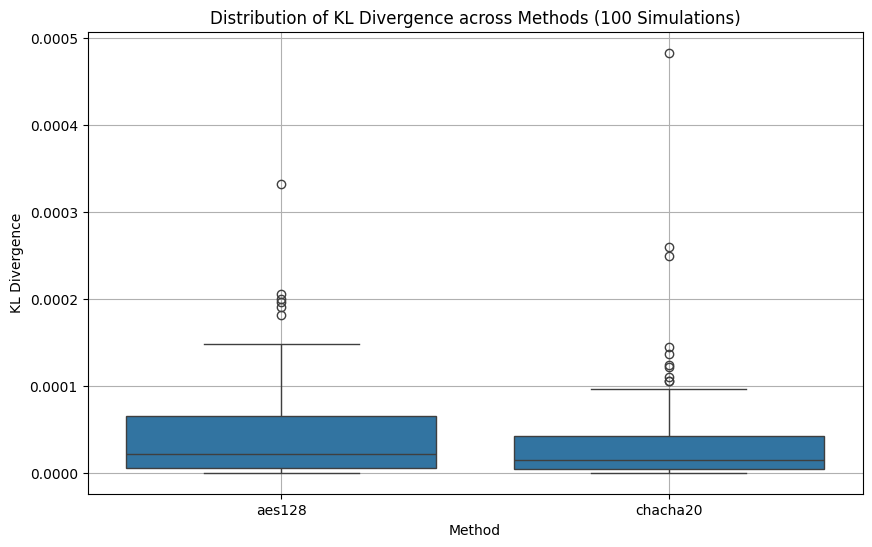

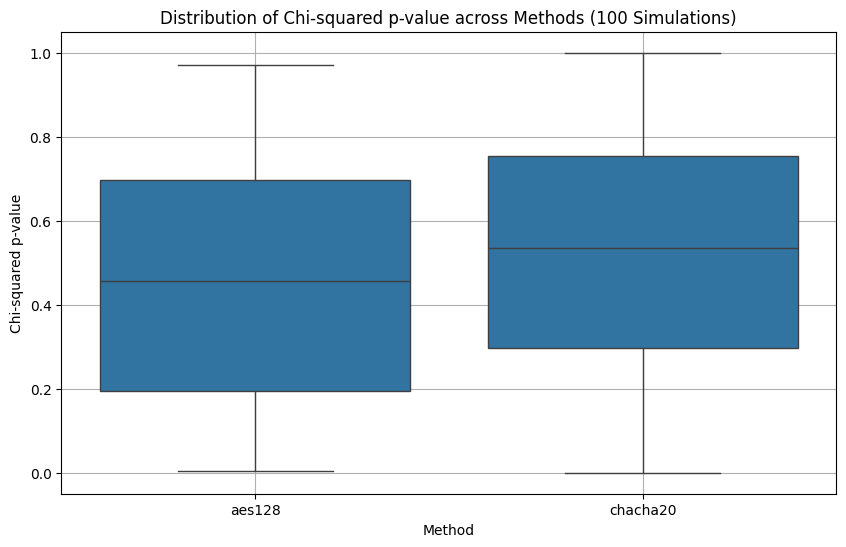

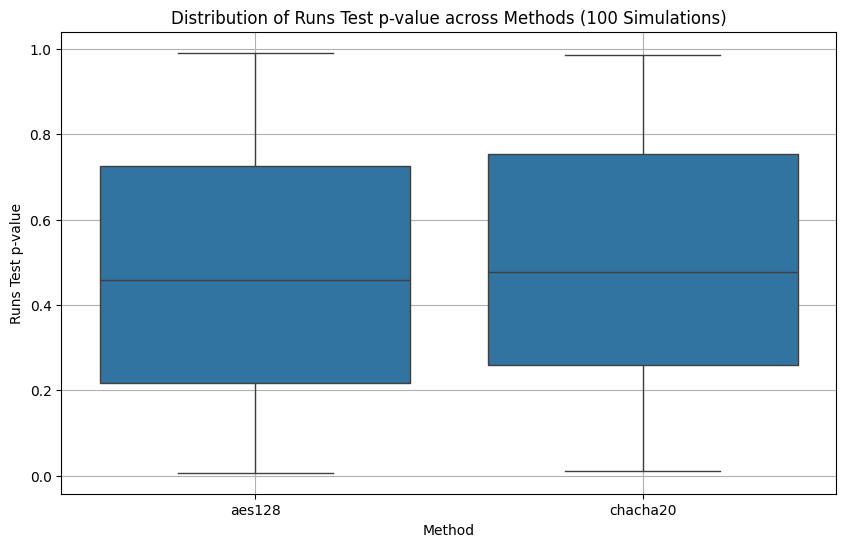

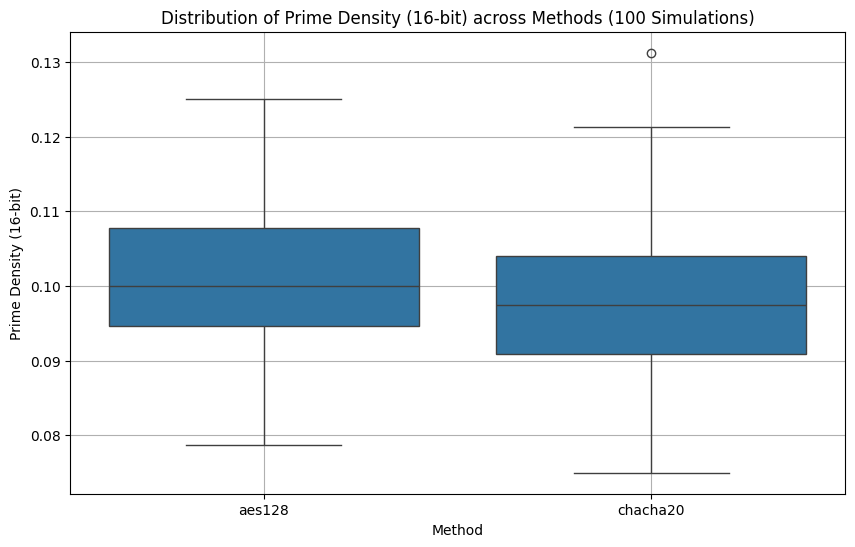

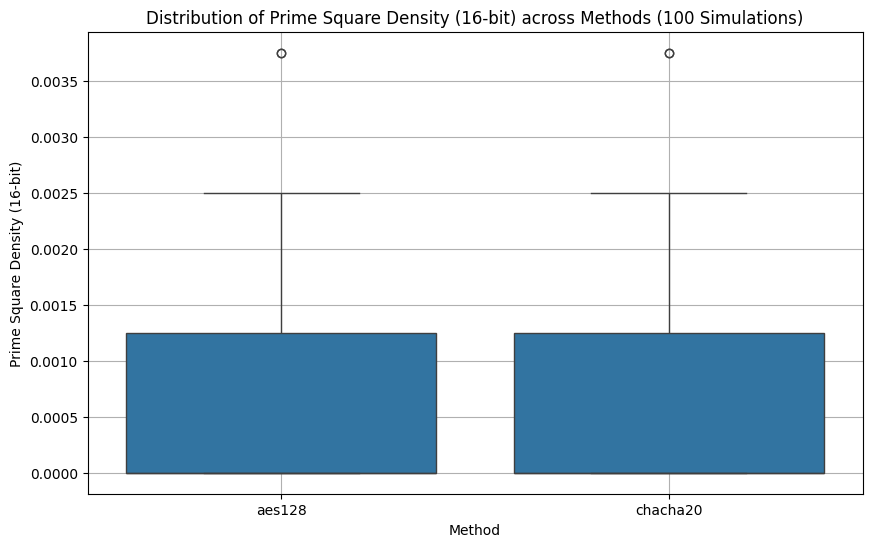

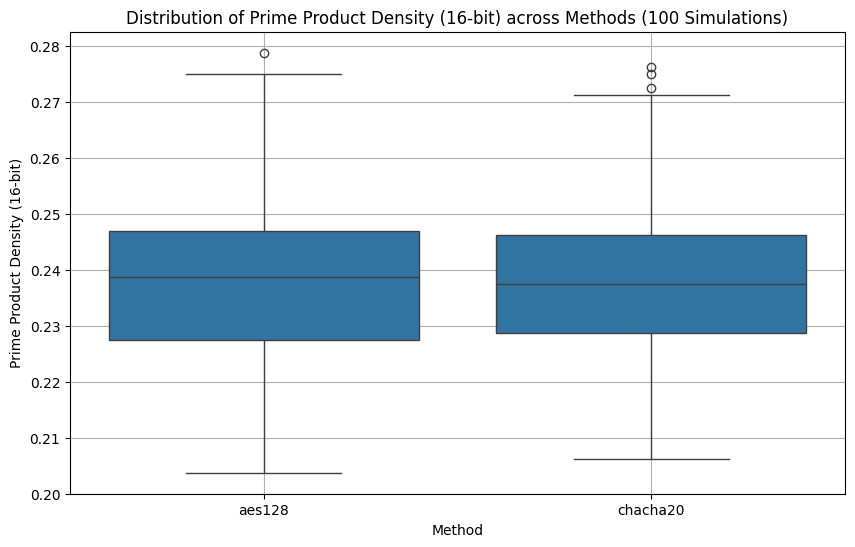

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is the DataFrame from the previous step containing results for AES128 and ChaCha20

methods = df['Method'].unique()
metrics_to_plot = [
    'KL Divergence',
    'Chi-squared p-value',
    'Runs Test p-value',
    'Prime Density (16-bit)',
    'Prime Square Density (16-bit)',
    'Prime Product Density (16-bit)'
]

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Method', y=metric, data=df)
    plt.title(f'Distribution of {metric} across Methods (100 Simulations)')
    plt.ylabel(metric)
    plt.xlabel('Method')
    plt.grid(True)
    plt.show()